In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

In [2]:
#!pip install scikit-learn

In [25]:
#monday
#load df
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

#remove rows with missing target: D3_within12months
X.dropna(axis=0, subset=['D3_within12months'], inplace=True)
y = X.D3_within12months
X.drop(['D3_within12months', 'loan_account_no'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=11, stratify = y)
object_columns = X.select_dtypes(include=['object','category']).columns
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output = False,drop='first').set_output(transform='pandas')

one_hot_encoded_object_X_train = ohe.fit_transform(X_train[object_columns])
one_hot_encoded_object_X_test = ohe.transform(X_test[object_columns])

final_X_train = pd.concat([one_hot_encoded_object_X_train, X_train.select_dtypes('number')], axis=1)
final_X_test = pd.concat([one_hot_encoded_object_X_test, X_test.select_dtypes('number')], axis=1)

X_train = final_X_train
X_test = final_X_test

In [26]:
print(f'Done loading {segment}')

Done loading high_CIBIL


# 1. Random Forest Tuning

## 1.1 Find best parameters

In [14]:
#RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold

# Define the model
mod = 'RF'
rf_model = RandomForestClassifier()

# Define the parameter distributions
param_distributions = {
    #from justin san
    'n_estimators': randint(50,500),
    'criterion': ["gini","entropy","log_loss"],
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2,21),
    'min_samples_leaf': randint(1,200),
    'max_features': ["sqrt","log2",None],
    'max_leaf_nodes': randint(10,1000),
    'min_weight_fraction_leaf': uniform(0.0,0.5),
    "random_state": [42]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up the random search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions, 
                                   n_iter=12, scoring='roc_auc', cv=cv, verbose=1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

cross_valid = pd.DataFrame(random_search.cv_results_)
cv_results_columns = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
                      'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score',
                      'rank_test_score']
cross_valid[cv_results_columns].to_csv(f'./CV_tables/cvtable{mod}_{segment}.csv', index = False)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}


RF (Jan. 14, 2025)
started:NTC:5:12 pm, ended 5:18 pm
NTC:Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}

started: low_CIBIL: 5:19 pm; ended 5:24 pm
low_CIBIL: Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}

started: mid_CIBIL: 5:24 pm, ended: 5:28 pm
mid_CIBIL: Best parameters found:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 872, 'min_samples_leaf': 48, 'min_samples_split': 16, 'min_weight_fraction_leaf': np.float64(0.04424625102595975), 'n_estimators': 264, 'random_state': 42}

started: high_CIBIL: 5:28 pm, ended: 5:33 pm
high_CIBIL: Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}

## 1.2 Load model builder

In [27]:
#RF
def RF_model_builder2(n_estimators = 100,
                    criterion = 'gini',
                    max_depth = None,
                    min_samples_split = 2,
                    min_samples_leaf = 1,
                    max_features = 'sqrt',
                    max_leaf_nodes = None,
                    min_weight_fraction_leaf = 0.0,
                    random_state = 42
                     ):
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion,
                                   max_depth = max_depth, 
                                   min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf, 
                                   max_features = max_features, 
                                   max_leaf_nodes = max_leaf_nodes,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf,
                                   random_state = 42)
    return model

## 1.3 Build tuned model
use best params found in step 1.1

In [28]:
#tuned using randomgridsearchcv; NTC here is just placeholder, it changes with segment accordingly
rf_NTC_v3 = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)

NTC and low_CIBIL same:Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}

In [30]:
#tuned using randomgridsearchcv; NTC here is just placeholder, it changes with segment accordingly
rf_mid_v3 = RF_model_builder2(n_estimators = 264,
                    criterion = 'entropy',
                    max_depth = 4,
                    min_samples_split = 16,
                    min_samples_leaf = 48,
                    max_features = 'log2',
                    max_leaf_nodes = 872,
                    min_weight_fraction_leaf = 0.04424625102595975,
                    random_state = 42)

mid_CIBIL: Best parameters found:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 872, 'min_samples_leaf': 48, 'min_samples_split': 16, 'min_weight_fraction_leaf': np.float64(0.04424625102595975), 'n_estimators': 264, 'random_state': 42}

In [38]:
#tuned using randomgridsearchcv; NTC here is just placeholder, it changes with segment accordingly
rf_high_v3 = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)

high_CIBIL: Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 24, 'min_samples_leaf': 45, 'min_samples_split': 2, 'min_weight_fraction_leaf': np.float64(0.007818203370596966), 'n_estimators': 58, 'random_state': 42}

## 1.4 Plot kfold aucs
Make sure to change model name

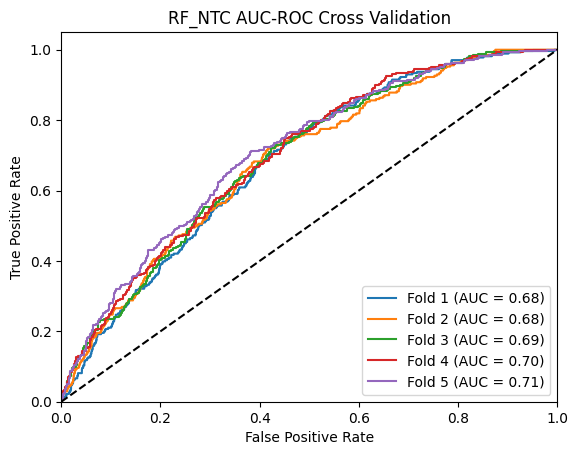

In [24]:
#RF - NTC
mod_seg = 'RF_NTC'
# kfold plotting
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = rf_NTC_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{mod_seg} AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

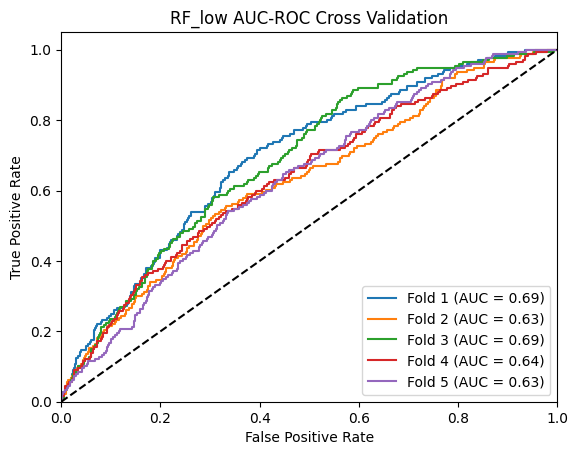

In [29]:
#RF - low_CIBIL
mod_seg = 'RF_low'
# kfold plotting
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = rf_NTC_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{mod_seg} AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

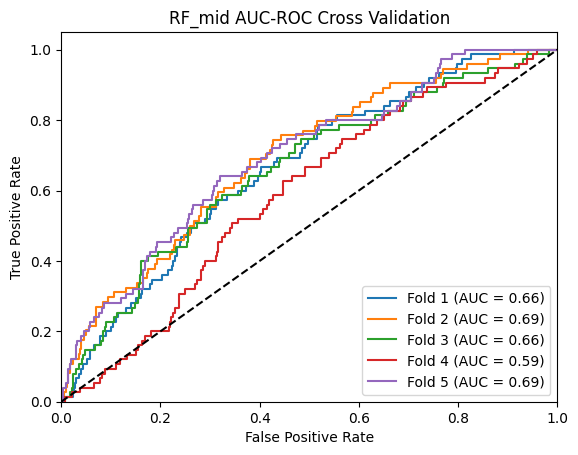

In [33]:
#RF - low_CIBIL
mod_seg = 'RF_mid'
# kfold plotting
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = rf_mid_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{mod_seg} AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

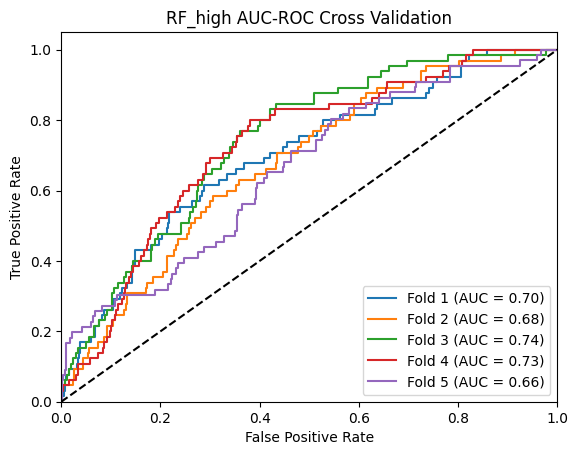

In [39]:
#RF - high_CIBIL
mod_seg = 'RF_high'
# kfold plotting
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = rf_mid_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{mod_seg} AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

# 2. XGBoost Tuning

In [10]:
!pip install xgboost --pre


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2.1 Find Best Parameters

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the model
mod = "XGB"
xgb_model = XGBClassifier()

# Define the parameter distributions
param_distributions = {
    'n_estimators': randint(50,500),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.00001, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),  
    'colsample_bylevel': uniform(0.5, 0.5),  
    'min_child_weight': randint(1, 200),  
    'gamma': uniform(0.0, 15.0),
    'reg_alpha': randint(0.0, 15), 
    'reg_lambda': randint(0.0, 100),
    'eta': uniform(0.01, 0.2),
    'random_state' : [42],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up the random search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, 
                                   n_iter=12, scoring='roc_auc', cv=cv, verbose=1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

cross_valid = pd.DataFrame(random_search.cv_results_)
cv_results_columns = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
                      'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
cross_valid[cv_results_columns].to_csv(f'./CV_tables/cvtable{mod}_{segment}.csv', index = False)

# Best parameters
print(f'Best parameters found {segment}: ', random_search.best_params_)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGB
NTC: started: 11:51 am, ended: 11:52 am
NTC : Best parameters found:  {'colsample_bylevel': 0.7806385987847482, 'colsample_bytree': 0.9083868719818244, 'eta': 0.10875911927287815, 'gamma': 7.840992440729911, 'learning_rate': 0.12827230550756488, 'max_depth': 3, 'min_child_weight': 63, 'n_estimators': 401, 'random_state': 42, 'reg_alpha': 6, 'reg_lambda': 51, 'subsample': 0.8253102287905535}

low_CIBIL: started: 1:11 pm, ended: 1:12 pm
low_CIBIL : Best parameters found:  {'colsample_bylevel': 0.9299702033681603, 'colsample_bytree': 0.8721230154351118, 'eta': 0.1000998503939086, 'gamma': 0.19897441739799793, 'learning_rate': 0.28267052670545584, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 395, 'random_state': 42, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.8736932106048627}

mid_CIBIL: started: 1: 28 pm, ended: 1:29 pm
mid_CIBIL : Best parameters found:  {'colsample_bylevel': 0.9299702033681603, 'colsample_bytree': 0.8721230154351118, 'eta': 0.1000998503939086, 'gamma': 0.19897441739799793, 'learning_rate': 0.28267052670545584, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 395, 'random_state': 42, 'reg_alpha': 4, 'reg_lambda': 1, 'subsample': 0.8736932106048627}

high_CIBIL: started: 1:34 pm, ended: 1:36 pm
high_CIBIL : Best parameters found:  {'colsample_bylevel': 0.8950877702656028, 'colsample_bytree': 0.8423839899124046, 'eta': 0.19526017570266982, 'gamma': 9.766155382529167, 'learning_rate': 0.27449790266313423, 'max_depth': 9, 'min_child_weight': 72, 'n_estimators': 317, 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 32, 'subsample': 0.6254233401144095}

# 2.2 Load XGB model builder

In [ ]:
#jied
def xgbc_model_builder3(n_estimators = 100,
                          max_depth = 6,
                          learning_rate=0.3,
                          subsample = 1,
                          colsample_bytree = 1,
                          colsample_bylevel = 1,
                          min_child_weight =1,
                          gamma = 0,
                          reg_alpha = 0,
                          reg_lambda = 1,
                          eta = 0.3,
                       random_state = 42):
    
    import xgboost as xgb
    model = xgb.XGBClassifier(n_estimators = n_estimators,
                              max_depth = max_depth,
                              learning_rate=learning_rate,
                              subsample = subsample,
                              colsample_bytree = colsample_bytree,
                              colsample_bylevel = colsample_bylevel,
                              min_child_weight =min_child_weight,
                              gamma = gamma,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              eta = eta,
                              random_state = 42,
                              enable_categorical=True,
                              n_jobs = -1,
                              objective = "binary:logistic")
    return model

# 2.3 Build tuned XGB model

In [ ]:
xgbc_ntc_v3 = xgbc_model_builder3(n_estimators = 317,
                          max_depth = 9,
                          learning_rate=0.27449790266313423,
                          subsample =  0.6254233401144095,
                          colsample_bytree = 0.8423839899124046,
                          colsample_bylevel = 0.8950877702656028,
                          min_child_weight =72,
                          gamma = 9.766155382529167,
                          reg_alpha = 1,
                          reg_lambda = 32,
                          eta = 0.19526017570266982,
                          random_state = 42)

#XGBC_ohe_model_auc(load_clean_data2('NTC'), xgbc_ntc_v3)

mid, same with low_CIBIL
high_CIBIL : Best parameters found:   {ok}

## 2.4 Plot Kfold Aucs

In [ ]:
#RF
# kfold plotting chatgpt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = xgbc_ntc_v3
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

# 3. LGB Tuning

In [17]:
#!pip install lightgbm

## 3.1 Find Best Parameter

In [27]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import StratifiedKFold

# Define the model
mod= 'LGB'
lgb_model = LGBMClassifier()

# Define the parameter distributions
param_distributions = {
    'boosting_type': ['gbdt','goss'],
    'max_depth': randint(1, 10),
    'learning_rate': loguniform(0.00001, 0.3),
    'min_split_gain': loguniform(0.00001, 0.3),
    'num_leaves': randint(15, 60),  
    'n_estimators': randint(50, 500),  
    'min_child_samples': randint(20, 500),  
    'subsample': uniform(0, 1.0),
    'reg_alpha': uniform(0.0, 15), 
    'reg_lambda': uniform(0.0, 100.0),
    'random_state':[42],
    'class_weight' : ['balanced'],
    'n_jobs' : [-1],
        'objective' : ['binary']
    
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up the random search
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_distributions, 
                                   n_iter=12, scoring='roc_auc', cv=cv, verbose=1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

cross_valid = pd.DataFrame(random_search.cv_results_)
cv_results_columns = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
                      'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
cross_valid[cv_results_columns].to_csv(f'./CV_tables/cvtable{mod}_{segment}.csv', index = False)

# Best parameters
print(f'Best parameters found {segment}: ', random_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 261, number of negative: 8203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 8464, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\emanlangit.AEONCREDIT\AppData\Roaming\Python\Python311\site-packages\lightgbm\sklearn.py", line 1284, in fit
    super().fit(
  File "C:\Users\emanlangit.AEONCREDIT\AppData\Roaming\Python\Python311\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
               

LGBM Jan. 15, 2025
NTC: started 11:23 am; ended 11:26 am
LGBM NTC: Best parameters found NTC:  {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': np.float64(0.21925421202433462), 'max_depth': 2, 'min_child_samples': 221, 'min_split_gain': np.float64(0.10144964926243934), 'n_estimators': 319, 'n_jobs': -1, 'num_leaves': 45, 'objective': 'binary', 'random_state': 42, 'reg_alpha': np.float64(13.828113525346753), 'reg_lambda': np.float64(8.84925020519195), 'subsample': np.float64(0.1959828624191452)}

low_CIBIL: started 11:27 am; ended 11:28 am
LGBM low_CIBIL: Best parameters found low_CIBIL:  {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': np.float64(0.21925421202433462), 'max_depth': 2, 'min_child_samples': 221, 'min_split_gain': np.float64(0.10144964926243934), 'n_estimators': 319, 'n_jobs': -1, 'num_leaves': 45, 'objective': 'binary', 'random_state': 42, 'reg_alpha': np.float64(13.828113525346753), 'reg_lambda': np.float64(8.84925020519195), 'subsample': np.float64(0.1959828624191452)}

mid_CIBIL: started 11:29 am; ended 11:30 am
LGBM mid_CIBIL: Best parameters found mid_CIBIL:  {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': np.float64(0.21925421202433462), 'max_depth': 2, 'min_child_samples': 221, 'min_split_gain': np.float64(0.10144964926243934), 'n_estimators': 319, 'n_jobs': -1, 'num_leaves': 45, 'objective': 'binary', 'random_state': 42, 'reg_alpha': np.float64(13.828113525346753), 'reg_lambda': np.float64(8.84925020519195), 'subsample': np.float64(0.1959828624191452)}


high_CIBIL: started 11:31 am; ended 11:32 am
LGBM high_CIBIL: Best parameters found high_CIBIL:  {'boosting_type': 'goss', 'class_weight': 'balanced', 'learning_rate': np.float64(0.01479540262121465), 'max_depth': 6, 'min_child_samples': 328, 'min_split_gain': np.float64(0.2199905443150214), 'n_estimators': 463, 'n_jobs': -1, 'num_leaves': 52, 'objective': 'binary', 'random_state': 42, 'reg_alpha': np.float64(0.011681487615214925), 'reg_lambda': np.float64(99.22115592912175), 'subsample': np.float64(0.6174815096277165)}

## 3.2 Load LGBM model

In [ ]:
#tuning lgb jied
def lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = -1,
        learning_rate = 0.1,
        min_split_gain = 0.0,
        num_leaves = 31,
        n_estimators = 100,
        min_child_samples = 50,
        subsample = 1,
        reg_alpha = 0,
        reg_lambda = 0,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'):
    
    import lightgbm as lgb
    model = lgb.LGBMClassifier(
        boosting_type = boosting_type,
        max_depth = max_depth,
        learning_rate = learning_rate,
        min_split_gain = min_split_gain,
        num_leaves = num_leaves,
        n_estimators = n_estimators,
        min_child_samples = min_child_samples,
        subsample = subsample,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        random_state = random_state,
        class_weight = class_weight,
        n_jobs = n_jobs,
        objective = objective
    )
    
    return model

## 3.3 Build tuned model
use best params found in step 3.1

In [ ]:
lgbc_ntc_v1 = lgbc_model_builder3(boosting_type = 'gbdt',
        max_depth = 3,
        learning_rate = 0.015302562995700694,
        min_split_gain = 0.005163643878518476,
        num_leaves = 55,
        n_estimators = 280,
        min_child_samples = 308,
        subsample = 0.4494506741382034,
        reg_alpha = 13.724395133156712,
        reg_lambda = 85.00385777897993,
        random_state = 42,
        class_weight = 'balanced',
        n_jobs = -1,
        objective = 'binary'
)
#lgbest

LGBM high_CIBIL: Best parameters found:  {ok}

In [ ]:
lgbc_ntc_v1

In [ ]:
#lGB
# kfold plotting chatgpt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = lgbc_ntc_v1
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

# Catboost Tuning

In [ ]:
#downgraded numpy to 1.26.4 to be compatible with catboost

In [2]:
print(np.__version__)

1.26.4


In [37]:
#!pip install numpy==1.26.4


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
#!pip install catboost

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached catboost-1.2.7-cp312-cp312-win_amd64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
Using cached catboost-1.2.7-cp312-cp312-win_amd64.whl (101.7 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1


In [2]:
#tuesday
#load df
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

#remove rows with missing target: D3_within12months
X.dropna(axis=0, subset=['D3_within12months'], inplace=True)
y = X.D3_within12months
X.drop(['D3_within12months', 'loan_account_no'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=11, stratify = y)
cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# from catboost import CatBoostClassifier, Pool
# train_data = Pool(data=X_train,
#              label = y_train,
#              cat_features=cat_features)

In [3]:
segment

'low_CIBIL'

In [4]:
cat_features

['product_description',
 'occupation_type',
 'gender',
 'marital_status',
 'nature_of_business',
 'manufacturer_grp',
 'channel_grp',
 'industry_grp',
 'branch_grp',
 'asset_model_grp',
 'res_city_grp',
 'res_state_grp',
 'res_resident_status_grp']

In [6]:
#X_train

## 4.1 Find catboost best parameters

In [ ]:
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import StratifiedKFold

# Define the model
mod = 'CB'
cb_model = CatBoostClassifier(cat_features=cat_features)

# Define the parameter distributions
param_distributions = {
    'depth': randint(1, 10),
    'learning_rate': uniform(0.00001, 0.3),
    'iterations': randint(50, 500),
    'l2_leaf_reg': uniform(0.0, 15),  
    'border_count': randint(32, 255),  
    'bagging_temperature': uniform(0.0, 3.0),  
    'random_strength': uniform(0, 10.0),
    'od_wait': randint(10, 101), 
    'auto_class_weights': ["Balanced"],
    'random_state':[42],
    'objective' : ['Logloss']
    
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Set up the random search
random_search = RandomizedSearchCV(estimator=cb_model, param_distributions=param_distributions, 
                                  n_iter=12, scoring='roc_auc', cv=cv, verbose=1, random_state=42)

#Fit the random search
random_search.fit(X_train,y_train)

cross_valid = pd.DataFrame(random_search.cv_results_)
cv_results_columns = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
                     'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
cross_valid[cv_results_columns].to_csv(f'./CV_tables/cvtable{mod}_{segment}.csv', index = False)

#Best parameters
print(f'Best parameters found:{segment} ', random_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.6734181	total: 246ms	remaining: 58.3s
1:	learn: 0.6619411	total: 315ms	remaining: 37.1s
2:	learn: 0.6608497	total: 333ms	remaining: 26.1s
3:	learn: 0.6466490	total: 394ms	remaining: 23s
4:	learn: 0.6382287	total: 455ms	remaining: 21.2s
5:	learn: 0.6272332	total: 518ms	remaining: 20s
6:	learn: 0.6154997	total: 583ms	remaining: 19.3s
7:	learn: 0.6033084	total: 657ms	remaining: 18.9s
8:	learn: 0.5935376	total: 728ms	remaining: 18.5s
9:	learn: 0.5886162	total: 825ms	remaining: 18.8s
10:	learn: 0.5861928	total: 895ms	remaining: 18.5s
11:	learn: 0.5809238	total: 949ms	remaining: 17.9s
12:	learn: 0.5739681	total: 1.01s	remaining: 17.5s
13:	learn: 0.5687619	total: 1.08s	remaining: 17.3s
14:	learn: 0.5636178	total: 1.16s	remaining: 17.2s
15:	learn: 0.5598029	total: 1.22s	remaining: 16.9s
16:	learn: 0.5591632	total: 1.29s	remaining: 16.7s
17:	learn: 0.5557951	total: 1.35s	remaining: 16.5s
18:	learn: 0.5533450	total: 1.41s	r

64:	learn: 0.5894047	total: 304ms	remaining: 1.63s
65:	learn: 0.5881883	total: 308ms	remaining: 1.62s
66:	learn: 0.5855152	total: 312ms	remaining: 1.61s
67:	learn: 0.5825386	total: 315ms	remaining: 1.6s
68:	learn: 0.5801764	total: 319ms	remaining: 1.59s
69:	learn: 0.5783927	total: 323ms	remaining: 1.58s
70:	learn: 0.5772962	total: 327ms	remaining: 1.58s
71:	learn: 0.5754273	total: 331ms	remaining: 1.57s
72:	learn: 0.5732579	total: 336ms	remaining: 1.56s
73:	learn: 0.5711684	total: 341ms	remaining: 1.56s
74:	learn: 0.5693919	total: 345ms	remaining: 1.55s
75:	learn: 0.5675809	total: 349ms	remaining: 1.55s
76:	learn: 0.5655843	total: 353ms	remaining: 1.54s
77:	learn: 0.5638236	total: 358ms	remaining: 1.54s
78:	learn: 0.5617951	total: 362ms	remaining: 1.53s
79:	learn: 0.5595197	total: 366ms	remaining: 1.52s
80:	learn: 0.5571086	total: 370ms	remaining: 1.52s
81:	learn: 0.5553315	total: 374ms	remaining: 1.51s
82:	learn: 0.5542190	total: 378ms	remaining: 1.5s
83:	learn: 0.5524874	total: 382ms

264:	learn: 0.3665112	total: 1.09s	remaining: 612ms
265:	learn: 0.3659203	total: 1.1s	remaining: 608ms
266:	learn: 0.3653608	total: 1.1s	remaining: 604ms
267:	learn: 0.3650058	total: 1.11s	remaining: 599ms
268:	learn: 0.3640988	total: 1.11s	remaining: 595ms
269:	learn: 0.3635869	total: 1.11s	remaining: 591ms
270:	learn: 0.3631786	total: 1.12s	remaining: 587ms
271:	learn: 0.3619210	total: 1.12s	remaining: 582ms
272:	learn: 0.3614648	total: 1.13s	remaining: 578ms
273:	learn: 0.3608500	total: 1.13s	remaining: 574ms
274:	learn: 0.3602508	total: 1.13s	remaining: 570ms
275:	learn: 0.3596637	total: 1.14s	remaining: 565ms
276:	learn: 0.3590963	total: 1.14s	remaining: 561ms
277:	learn: 0.3584267	total: 1.15s	remaining: 557ms
278:	learn: 0.3576860	total: 1.15s	remaining: 553ms
279:	learn: 0.3571754	total: 1.16s	remaining: 549ms
280:	learn: 0.3565947	total: 1.16s	remaining: 546ms
281:	learn: 0.3559220	total: 1.17s	remaining: 542ms
282:	learn: 0.3552713	total: 1.17s	remaining: 538ms
283:	learn: 0.

13:	learn: 0.6444655	total: 105ms	remaining: 3s
14:	learn: 0.6433110	total: 110ms	remaining: 2.91s
15:	learn: 0.6416316	total: 113ms	remaining: 2.8s
16:	learn: 0.6406073	total: 116ms	remaining: 2.71s
17:	learn: 0.6388756	total: 120ms	remaining: 2.63s
18:	learn: 0.6362403	total: 124ms	remaining: 2.57s
19:	learn: 0.6332885	total: 127ms	remaining: 2.5s
20:	learn: 0.6326934	total: 131ms	remaining: 2.45s
21:	learn: 0.6306712	total: 135ms	remaining: 2.4s
22:	learn: 0.6304060	total: 138ms	remaining: 2.33s
23:	learn: 0.6285141	total: 141ms	remaining: 2.28s
24:	learn: 0.6273476	total: 144ms	remaining: 2.23s
25:	learn: 0.6251770	total: 147ms	remaining: 2.19s
26:	learn: 0.6230504	total: 151ms	remaining: 2.16s
27:	learn: 0.6198315	total: 154ms	remaining: 2.12s
28:	learn: 0.6194717	total: 157ms	remaining: 2.08s
29:	learn: 0.6190241	total: 161ms	remaining: 2.06s
30:	learn: 0.6184266	total: 164ms	remaining: 2.02s
31:	learn: 0.6174139	total: 167ms	remaining: 1.99s
32:	learn: 0.6160523	total: 171ms	rem

173:	learn: 0.4468934	total: 698ms	remaining: 959ms
174:	learn: 0.4464446	total: 703ms	remaining: 956ms
175:	learn: 0.4460736	total: 707ms	remaining: 952ms
176:	learn: 0.4446497	total: 710ms	remaining: 947ms
177:	learn: 0.4437690	total: 714ms	remaining: 943ms
178:	learn: 0.4427651	total: 718ms	remaining: 938ms
179:	learn: 0.4420529	total: 722ms	remaining: 934ms
180:	learn: 0.4411708	total: 726ms	remaining: 930ms
181:	learn: 0.4400406	total: 730ms	remaining: 926ms
182:	learn: 0.4391589	total: 733ms	remaining: 922ms
183:	learn: 0.4385015	total: 737ms	remaining: 917ms
184:	learn: 0.4379008	total: 740ms	remaining: 912ms
185:	learn: 0.4372310	total: 744ms	remaining: 908ms
186:	learn: 0.4364903	total: 749ms	remaining: 905ms
187:	learn: 0.4357445	total: 752ms	remaining: 900ms
188:	learn: 0.4343945	total: 756ms	remaining: 896ms
189:	learn: 0.4338567	total: 761ms	remaining: 893ms
190:	learn: 0.4332747	total: 765ms	remaining: 889ms
191:	learn: 0.4324351	total: 769ms	remaining: 885ms
192:	learn: 

377:	learn: 0.3203482	total: 1.49s	remaining: 138ms
378:	learn: 0.3198490	total: 1.5s	remaining: 134ms
379:	learn: 0.3192658	total: 1.5s	remaining: 130ms
380:	learn: 0.3190314	total: 1.5s	remaining: 126ms
381:	learn: 0.3186739	total: 1.51s	remaining: 123ms
382:	learn: 0.3180980	total: 1.51s	remaining: 119ms
383:	learn: 0.3175652	total: 1.52s	remaining: 115ms
384:	learn: 0.3172676	total: 1.52s	remaining: 111ms
385:	learn: 0.3164729	total: 1.53s	remaining: 107ms
386:	learn: 0.3159982	total: 1.53s	remaining: 103ms
387:	learn: 0.3156555	total: 1.53s	remaining: 98.9ms
388:	learn: 0.3152745	total: 1.54s	remaining: 95ms
389:	learn: 0.3147387	total: 1.54s	remaining: 91.1ms
390:	learn: 0.3144162	total: 1.55s	remaining: 87.1ms
391:	learn: 0.3139504	total: 1.55s	remaining: 83.2ms
392:	learn: 0.3133525	total: 1.56s	remaining: 79.2ms
393:	learn: 0.3129830	total: 1.56s	remaining: 75.3ms
394:	learn: 0.3125672	total: 1.56s	remaining: 71.3ms
395:	learn: 0.3117182	total: 1.57s	remaining: 67.4ms
396:	lea

131:	learn: 0.4780103	total: 622ms	remaining: 1.32s
132:	learn: 0.4770574	total: 626ms	remaining: 1.32s
133:	learn: 0.4763870	total: 631ms	remaining: 1.31s
134:	learn: 0.4753522	total: 635ms	remaining: 1.31s
135:	learn: 0.4744148	total: 640ms	remaining: 1.3s
136:	learn: 0.4735803	total: 645ms	remaining: 1.3s
137:	learn: 0.4724780	total: 650ms	remaining: 1.29s
138:	learn: 0.4714987	total: 654ms	remaining: 1.29s
139:	learn: 0.4704790	total: 659ms	remaining: 1.28s
140:	learn: 0.4693477	total: 664ms	remaining: 1.28s
141:	learn: 0.4684601	total: 668ms	remaining: 1.27s
142:	learn: 0.4670349	total: 672ms	remaining: 1.27s
143:	learn: 0.4658717	total: 677ms	remaining: 1.26s
144:	learn: 0.4640025	total: 681ms	remaining: 1.26s
145:	learn: 0.4632304	total: 685ms	remaining: 1.25s
146:	learn: 0.4625559	total: 690ms	remaining: 1.25s
147:	learn: 0.4615788	total: 694ms	remaining: 1.24s
148:	learn: 0.4606421	total: 699ms	remaining: 1.24s
149:	learn: 0.4599645	total: 703ms	remaining: 1.23s
150:	learn: 0.

293:	learn: 0.3554489	total: 1.43s	remaining: 578ms
294:	learn: 0.3551733	total: 1.43s	remaining: 574ms
295:	learn: 0.3545030	total: 1.44s	remaining: 569ms
296:	learn: 0.3541489	total: 1.44s	remaining: 564ms
297:	learn: 0.3536673	total: 1.45s	remaining: 559ms
298:	learn: 0.3532853	total: 1.45s	remaining: 554ms
299:	learn: 0.3529396	total: 1.46s	remaining: 548ms
300:	learn: 0.3523048	total: 1.46s	remaining: 543ms
301:	learn: 0.3513290	total: 1.46s	remaining: 538ms
302:	learn: 0.3508476	total: 1.47s	remaining: 533ms
303:	learn: 0.3503057	total: 1.47s	remaining: 528ms
304:	learn: 0.3497737	total: 1.48s	remaining: 523ms
305:	learn: 0.3491816	total: 1.48s	remaining: 518ms
306:	learn: 0.3486887	total: 1.48s	remaining: 512ms
307:	learn: 0.3480090	total: 1.49s	remaining: 507ms
308:	learn: 0.3476539	total: 1.49s	remaining: 502ms
309:	learn: 0.3467063	total: 1.5s	remaining: 497ms
310:	learn: 0.3462996	total: 1.5s	remaining: 492ms
311:	learn: 0.3458791	total: 1.5s	remaining: 486ms
312:	learn: 0.3

67:	learn: 0.5840403	total: 284ms	remaining: 1.44s
68:	learn: 0.5829421	total: 287ms	remaining: 1.43s
69:	learn: 0.5808047	total: 291ms	remaining: 1.42s
70:	learn: 0.5795268	total: 294ms	remaining: 1.42s
71:	learn: 0.5769268	total: 298ms	remaining: 1.41s
72:	learn: 0.5746787	total: 302ms	remaining: 1.41s
73:	learn: 0.5732758	total: 306ms	remaining: 1.4s
74:	learn: 0.5712849	total: 310ms	remaining: 1.4s
75:	learn: 0.5678934	total: 314ms	remaining: 1.39s
76:	learn: 0.5664882	total: 317ms	remaining: 1.39s
77:	learn: 0.5649029	total: 321ms	remaining: 1.38s
78:	learn: 0.5619428	total: 325ms	remaining: 1.38s
79:	learn: 0.5594382	total: 329ms	remaining: 1.37s
80:	learn: 0.5569753	total: 333ms	remaining: 1.36s
81:	learn: 0.5548225	total: 336ms	remaining: 1.36s
82:	learn: 0.5530832	total: 340ms	remaining: 1.35s
83:	learn: 0.5513718	total: 343ms	remaining: 1.34s
84:	learn: 0.5490406	total: 347ms	remaining: 1.34s
85:	learn: 0.5476508	total: 352ms	remaining: 1.34s
86:	learn: 0.5461998	total: 356ms

262:	learn: 0.3824335	total: 1.08s	remaining: 616ms
263:	learn: 0.3817484	total: 1.08s	remaining: 612ms
264:	learn: 0.3813410	total: 1.09s	remaining: 607ms
265:	learn: 0.3805239	total: 1.09s	remaining: 603ms
266:	learn: 0.3801029	total: 1.1s	remaining: 600ms
267:	learn: 0.3797206	total: 1.1s	remaining: 596ms
268:	learn: 0.3791120	total: 1.1s	remaining: 592ms
269:	learn: 0.3782094	total: 1.11s	remaining: 588ms
270:	learn: 0.3773948	total: 1.11s	remaining: 584ms
271:	learn: 0.3767305	total: 1.12s	remaining: 579ms
272:	learn: 0.3763762	total: 1.12s	remaining: 575ms
273:	learn: 0.3759212	total: 1.12s	remaining: 570ms
274:	learn: 0.3751409	total: 1.13s	remaining: 567ms
275:	learn: 0.3745637	total: 1.13s	remaining: 563ms
276:	learn: 0.3740095	total: 1.14s	remaining: 558ms
277:	learn: 0.3739154	total: 1.14s	remaining: 554ms
278:	learn: 0.3736775	total: 1.14s	remaining: 550ms
279:	learn: 0.3731397	total: 1.15s	remaining: 545ms
280:	learn: 0.3725703	total: 1.15s	remaining: 541ms
281:	learn: 0.3

25:	learn: 0.6279113	total: 128ms	remaining: 1.91s
26:	learn: 0.6264275	total: 132ms	remaining: 1.89s
27:	learn: 0.6260867	total: 136ms	remaining: 1.86s
28:	learn: 0.6252433	total: 139ms	remaining: 1.84s
29:	learn: 0.6238468	total: 143ms	remaining: 1.83s
30:	learn: 0.6201680	total: 148ms	remaining: 1.82s
31:	learn: 0.6201345	total: 152ms	remaining: 1.81s
32:	learn: 0.6190921	total: 155ms	remaining: 1.79s
33:	learn: 0.6184707	total: 160ms	remaining: 1.78s
34:	learn: 0.6161726	total: 164ms	remaining: 1.77s
35:	learn: 0.6156048	total: 168ms	remaining: 1.76s
36:	learn: 0.6149071	total: 173ms	remaining: 1.75s
37:	learn: 0.6144217	total: 177ms	remaining: 1.75s
38:	learn: 0.6135277	total: 181ms	remaining: 1.73s
39:	learn: 0.6133288	total: 184ms	remaining: 1.72s
40:	learn: 0.6128892	total: 188ms	remaining: 1.71s
41:	learn: 0.6124957	total: 192ms	remaining: 1.7s
42:	learn: 0.6110430	total: 196ms	remaining: 1.69s
43:	learn: 0.6101275	total: 200ms	remaining: 1.68s
44:	learn: 0.6088646	total: 204m

216:	learn: 0.4148878	total: 922ms	remaining: 833ms
217:	learn: 0.4144811	total: 926ms	remaining: 829ms
218:	learn: 0.4136988	total: 930ms	remaining: 824ms
219:	learn: 0.4125793	total: 934ms	remaining: 819ms
220:	learn: 0.4118918	total: 937ms	remaining: 814ms
221:	learn: 0.4113596	total: 941ms	remaining: 810ms
222:	learn: 0.4103619	total: 945ms	remaining: 805ms
223:	learn: 0.4095482	total: 948ms	remaining: 800ms
224:	learn: 0.4088385	total: 953ms	remaining: 796ms
225:	learn: 0.4083499	total: 956ms	remaining: 791ms
226:	learn: 0.4077421	total: 960ms	remaining: 787ms
227:	learn: 0.4074372	total: 964ms	remaining: 782ms
228:	learn: 0.4070209	total: 968ms	remaining: 778ms
229:	learn: 0.4064724	total: 973ms	remaining: 774ms
230:	learn: 0.4056993	total: 977ms	remaining: 769ms
231:	learn: 0.4051713	total: 980ms	remaining: 765ms
232:	learn: 0.4045962	total: 984ms	remaining: 760ms
233:	learn: 0.4038495	total: 988ms	remaining: 756ms
234:	learn: 0.4032860	total: 992ms	remaining: 752ms
235:	learn: 

0:	learn: 0.6401952	total: 19.2ms	remaining: 6.19s
1:	learn: 0.6031906	total: 34.6ms	remaining: 5.56s
2:	learn: 0.5769193	total: 46.2ms	remaining: 4.92s
3:	learn: 0.5558383	total: 54ms	remaining: 4.3s
4:	learn: 0.5377755	total: 61.2ms	remaining: 3.89s
5:	learn: 0.5249532	total: 68.1ms	remaining: 3.6s
6:	learn: 0.5134793	total: 74.2ms	remaining: 3.35s
7:	learn: 0.5061167	total: 80.3ms	remaining: 3.16s
8:	learn: 0.4908332	total: 86.8ms	remaining: 3.03s
9:	learn: 0.4789704	total: 92.5ms	remaining: 2.89s
10:	learn: 0.4654558	total: 99.4ms	remaining: 2.82s
11:	learn: 0.4566987	total: 106ms	remaining: 2.74s
12:	learn: 0.4508781	total: 112ms	remaining: 2.66s
13:	learn: 0.4409097	total: 118ms	remaining: 2.6s
14:	learn: 0.4339901	total: 124ms	remaining: 2.54s
15:	learn: 0.4273424	total: 130ms	remaining: 2.49s
16:	learn: 0.4172316	total: 135ms	remaining: 2.44s
17:	learn: 0.4113929	total: 141ms	remaining: 2.39s
18:	learn: 0.4043306	total: 147ms	remaining: 2.35s
19:	learn: 0.3951508	total: 153ms	r

182:	learn: 0.0639384	total: 1.22s	remaining: 930ms
183:	learn: 0.0636228	total: 1.22s	remaining: 924ms
184:	learn: 0.0629059	total: 1.23s	remaining: 917ms
185:	learn: 0.0622419	total: 1.24s	remaining: 911ms
186:	learn: 0.0616312	total: 1.24s	remaining: 903ms
187:	learn: 0.0612089	total: 1.25s	remaining: 897ms
188:	learn: 0.0604615	total: 1.25s	remaining: 890ms
189:	learn: 0.0598546	total: 1.26s	remaining: 883ms
190:	learn: 0.0596162	total: 1.27s	remaining: 876ms
191:	learn: 0.0594140	total: 1.27s	remaining: 869ms
192:	learn: 0.0589553	total: 1.28s	remaining: 862ms
193:	learn: 0.0586265	total: 1.28s	remaining: 855ms
194:	learn: 0.0581144	total: 1.29s	remaining: 848ms
195:	learn: 0.0574935	total: 1.3s	remaining: 841ms
196:	learn: 0.0571163	total: 1.3s	remaining: 834ms
197:	learn: 0.0568914	total: 1.31s	remaining: 827ms
198:	learn: 0.0565896	total: 1.32s	remaining: 820ms
199:	learn: 0.0563259	total: 1.32s	remaining: 813ms
200:	learn: 0.0557517	total: 1.33s	remaining: 806ms
201:	learn: 0.

32:	learn: 0.3310269	total: 264ms	remaining: 2.32s
33:	learn: 0.3245708	total: 270ms	remaining: 2.3s
34:	learn: 0.3194761	total: 276ms	remaining: 2.27s
35:	learn: 0.3159971	total: 282ms	remaining: 2.25s
36:	learn: 0.3113665	total: 288ms	remaining: 2.23s
37:	learn: 0.3069161	total: 295ms	remaining: 2.21s
38:	learn: 0.3017122	total: 302ms	remaining: 2.2s
39:	learn: 0.2959286	total: 309ms	remaining: 2.18s
40:	learn: 0.2880563	total: 316ms	remaining: 2.17s
41:	learn: 0.2843183	total: 322ms	remaining: 2.16s
42:	learn: 0.2814054	total: 329ms	remaining: 2.14s
43:	learn: 0.2768732	total: 336ms	remaining: 2.13s
44:	learn: 0.2718137	total: 344ms	remaining: 2.12s
45:	learn: 0.2683577	total: 351ms	remaining: 2.11s
46:	learn: 0.2653735	total: 358ms	remaining: 2.1s
47:	learn: 0.2629390	total: 365ms	remaining: 2.09s
48:	learn: 0.2559880	total: 373ms	remaining: 2.08s
49:	learn: 0.2513735	total: 379ms	remaining: 2.07s
50:	learn: 0.2492740	total: 386ms	remaining: 2.06s
51:	learn: 0.2468611	total: 393ms	

217:	learn: 0.0492579	total: 1.46s	remaining: 704ms
218:	learn: 0.0487601	total: 1.47s	remaining: 697ms
219:	learn: 0.0484617	total: 1.47s	remaining: 690ms
220:	learn: 0.0481225	total: 1.48s	remaining: 684ms
221:	learn: 0.0477733	total: 1.49s	remaining: 677ms
222:	learn: 0.0473707	total: 1.49s	remaining: 670ms
223:	learn: 0.0471005	total: 1.5s	remaining: 663ms
224:	learn: 0.0468087	total: 1.51s	remaining: 656ms
225:	learn: 0.0463887	total: 1.51s	remaining: 649ms
226:	learn: 0.0458983	total: 1.52s	remaining: 643ms
227:	learn: 0.0456426	total: 1.52s	remaining: 636ms
228:	learn: 0.0455072	total: 1.53s	remaining: 628ms
229:	learn: 0.0452599	total: 1.54s	remaining: 622ms
230:	learn: 0.0450957	total: 1.54s	remaining: 615ms
231:	learn: 0.0448486	total: 1.55s	remaining: 608ms
232:	learn: 0.0445873	total: 1.56s	remaining: 601ms
233:	learn: 0.0441334	total: 1.56s	remaining: 594ms
234:	learn: 0.0437911	total: 1.57s	remaining: 587ms
235:	learn: 0.0435861	total: 1.57s	remaining: 581ms
236:	learn: 0

59:	learn: 0.2023138	total: 453ms	remaining: 1.99s
60:	learn: 0.1991420	total: 460ms	remaining: 1.98s
61:	learn: 0.1979139	total: 467ms	remaining: 1.97s
62:	learn: 0.1956062	total: 473ms	remaining: 1.95s
63:	learn: 0.1924707	total: 480ms	remaining: 1.94s
64:	learn: 0.1901505	total: 487ms	remaining: 1.93s
65:	learn: 0.1878630	total: 494ms	remaining: 1.92s
66:	learn: 0.1863987	total: 500ms	remaining: 1.91s
67:	learn: 0.1838915	total: 507ms	remaining: 1.9s
68:	learn: 0.1811472	total: 514ms	remaining: 1.89s
69:	learn: 0.1782905	total: 521ms	remaining: 1.88s
70:	learn: 0.1754233	total: 529ms	remaining: 1.88s
71:	learn: 0.1735115	total: 536ms	remaining: 1.87s
72:	learn: 0.1717848	total: 543ms	remaining: 1.86s
73:	learn: 0.1686972	total: 549ms	remaining: 1.85s
74:	learn: 0.1668454	total: 556ms	remaining: 1.84s
75:	learn: 0.1655304	total: 564ms	remaining: 1.83s
76:	learn: 0.1634139	total: 571ms	remaining: 1.82s
77:	learn: 0.1601481	total: 579ms	remaining: 1.82s
78:	learn: 0.1574137	total: 587m

235:	learn: 0.0420456	total: 1.67s	remaining: 614ms
236:	learn: 0.0416517	total: 1.67s	remaining: 607ms
237:	learn: 0.0412833	total: 1.68s	remaining: 600ms
238:	learn: 0.0409727	total: 1.69s	remaining: 592ms
239:	learn: 0.0404580	total: 1.69s	remaining: 585ms
240:	learn: 0.0402696	total: 1.7s	remaining: 578ms
241:	learn: 0.0400721	total: 1.71s	remaining: 572ms
242:	learn: 0.0397435	total: 1.72s	remaining: 568ms
243:	learn: 0.0394534	total: 1.74s	remaining: 565ms
244:	learn: 0.0393296	total: 1.75s	remaining: 559ms
245:	learn: 0.0391136	total: 1.77s	remaining: 554ms
246:	learn: 0.0389440	total: 1.78s	remaining: 547ms
247:	learn: 0.0387134	total: 1.79s	remaining: 541ms
248:	learn: 0.0386627	total: 1.8s	remaining: 534ms
249:	learn: 0.0385536	total: 1.8s	remaining: 527ms
250:	learn: 0.0384271	total: 1.81s	remaining: 520ms
251:	learn: 0.0381859	total: 1.82s	remaining: 513ms
252:	learn: 0.0379526	total: 1.83s	remaining: 506ms
253:	learn: 0.0377162	total: 1.84s	remaining: 501ms
254:	learn: 0.0

97:	learn: 0.1433199	total: 702ms	remaining: 1.61s
98:	learn: 0.1424546	total: 709ms	remaining: 1.6s
99:	learn: 0.1413522	total: 716ms	remaining: 1.6s
100:	learn: 0.1399341	total: 724ms	remaining: 1.59s
101:	learn: 0.1387652	total: 731ms	remaining: 1.58s
102:	learn: 0.1373083	total: 738ms	remaining: 1.58s
103:	learn: 0.1359074	total: 744ms	remaining: 1.57s
104:	learn: 0.1341280	total: 751ms	remaining: 1.56s
105:	learn: 0.1328909	total: 757ms	remaining: 1.55s
106:	learn: 0.1300743	total: 764ms	remaining: 1.54s
107:	learn: 0.1287534	total: 771ms	remaining: 1.53s
108:	learn: 0.1278774	total: 777ms	remaining: 1.53s
109:	learn: 0.1264089	total: 784ms	remaining: 1.52s
110:	learn: 0.1241398	total: 792ms	remaining: 1.51s
111:	learn: 0.1227707	total: 799ms	remaining: 1.5s
112:	learn: 0.1208290	total: 806ms	remaining: 1.5s
113:	learn: 0.1197384	total: 812ms	remaining: 1.49s
114:	learn: 0.1184276	total: 820ms	remaining: 1.48s
115:	learn: 0.1172794	total: 826ms	remaining: 1.47s
116:	learn: 0.11570

273:	learn: 0.0329239	total: 2.13s	remaining: 382ms
274:	learn: 0.0326309	total: 2.14s	remaining: 374ms
275:	learn: 0.0324162	total: 2.15s	remaining: 366ms
276:	learn: 0.0322124	total: 2.16s	remaining: 358ms
277:	learn: 0.0320548	total: 2.16s	remaining: 350ms
278:	learn: 0.0319290	total: 2.17s	remaining: 342ms
279:	learn: 0.0317326	total: 2.18s	remaining: 334ms
280:	learn: 0.0314598	total: 2.18s	remaining: 326ms
281:	learn: 0.0313058	total: 2.19s	remaining: 318ms
282:	learn: 0.0311593	total: 2.19s	remaining: 310ms
283:	learn: 0.0310079	total: 2.2s	remaining: 302ms
284:	learn: 0.0308177	total: 2.21s	remaining: 295ms
285:	learn: 0.0307546	total: 2.22s	remaining: 287ms
286:	learn: 0.0305341	total: 2.22s	remaining: 279ms
287:	learn: 0.0304140	total: 2.23s	remaining: 271ms
288:	learn: 0.0303208	total: 2.24s	remaining: 263ms
289:	learn: 0.0301917	total: 2.24s	remaining: 255ms
290:	learn: 0.0300249	total: 2.25s	remaining: 247ms
291:	learn: 0.0298243	total: 2.26s	remaining: 240ms
292:	learn: 0

124:	learn: 0.0944230	total: 1.04s	remaining: 1.65s
125:	learn: 0.0934878	total: 1.05s	remaining: 1.64s
126:	learn: 0.0925797	total: 1.06s	remaining: 1.64s
127:	learn: 0.0917320	total: 1.07s	remaining: 1.63s
128:	learn: 0.0912539	total: 1.08s	remaining: 1.62s
129:	learn: 0.0903382	total: 1.08s	remaining: 1.61s
130:	learn: 0.0894118	total: 1.09s	remaining: 1.6s
131:	learn: 0.0886188	total: 1.1s	remaining: 1.59s
132:	learn: 0.0878123	total: 1.11s	remaining: 1.58s
133:	learn: 0.0866695	total: 1.11s	remaining: 1.57s
134:	learn: 0.0862306	total: 1.12s	remaining: 1.56s
135:	learn: 0.0853698	total: 1.13s	remaining: 1.55s
136:	learn: 0.0848526	total: 1.14s	remaining: 1.54s
137:	learn: 0.0835643	total: 1.14s	remaining: 1.53s
138:	learn: 0.0832354	total: 1.15s	remaining: 1.52s
139:	learn: 0.0826609	total: 1.16s	remaining: 1.51s
140:	learn: 0.0817077	total: 1.16s	remaining: 1.5s
141:	learn: 0.0810323	total: 1.17s	remaining: 1.49s
142:	learn: 0.0802627	total: 1.18s	remaining: 1.48s
143:	learn: 0.0

300:	learn: 0.0267094	total: 2.28s	remaining: 167ms
301:	learn: 0.0266313	total: 2.3s	remaining: 160ms
302:	learn: 0.0265331	total: 2.31s	remaining: 153ms
303:	learn: 0.0264106	total: 2.32s	remaining: 145ms
304:	learn: 0.0262059	total: 2.33s	remaining: 137ms
305:	learn: 0.0260696	total: 2.33s	remaining: 130ms
306:	learn: 0.0259401	total: 2.34s	remaining: 122ms
307:	learn: 0.0257272	total: 2.35s	remaining: 114ms
308:	learn: 0.0255681	total: 2.35s	remaining: 107ms
309:	learn: 0.0254179	total: 2.36s	remaining: 98.9ms
310:	learn: 0.0252824	total: 2.36s	remaining: 91.2ms
311:	learn: 0.0250918	total: 2.37s	remaining: 83.6ms
312:	learn: 0.0249315	total: 2.38s	remaining: 75.9ms
313:	learn: 0.0247804	total: 2.38s	remaining: 68.3ms
314:	learn: 0.0246125	total: 2.39s	remaining: 60.7ms
315:	learn: 0.0244406	total: 2.4s	remaining: 53.1ms
316:	learn: 0.0242309	total: 2.4s	remaining: 45.5ms
317:	learn: 0.0241385	total: 2.41s	remaining: 37.9ms
318:	learn: 0.0240289	total: 2.42s	remaining: 30.3ms
319:	

148:	learn: 0.5967330	total: 1.26s	remaining: 2.77s
149:	learn: 0.5963503	total: 1.27s	remaining: 2.76s
150:	learn: 0.5960304	total: 1.27s	remaining: 2.75s
151:	learn: 0.5956405	total: 1.28s	remaining: 2.74s
152:	learn: 0.5952225	total: 1.29s	remaining: 2.73s
153:	learn: 0.5950806	total: 1.3s	remaining: 2.72s
154:	learn: 0.5947239	total: 1.3s	remaining: 2.71s
155:	learn: 0.5941642	total: 1.31s	remaining: 2.7s
156:	learn: 0.5937994	total: 1.32s	remaining: 2.69s
157:	learn: 0.5935975	total: 1.32s	remaining: 2.68s
158:	learn: 0.5934314	total: 1.33s	remaining: 2.66s
159:	learn: 0.5927202	total: 1.34s	remaining: 2.65s
160:	learn: 0.5922917	total: 1.35s	remaining: 2.64s
161:	learn: 0.5920642	total: 1.35s	remaining: 2.63s
162:	learn: 0.5917449	total: 1.36s	remaining: 2.62s
163:	learn: 0.5913996	total: 1.37s	remaining: 2.61s
164:	learn: 0.5909706	total: 1.38s	remaining: 2.6s
165:	learn: 0.5904402	total: 1.38s	remaining: 2.59s
166:	learn: 0.5901639	total: 1.39s	remaining: 2.58s
167:	learn: 0.58

337:	learn: 0.5441544	total: 2.71s	remaining: 1.11s
338:	learn: 0.5439705	total: 2.71s	remaining: 1.1s
339:	learn: 0.5434984	total: 2.72s	remaining: 1.1s
340:	learn: 0.5432785	total: 2.73s	remaining: 1.09s
341:	learn: 0.5430534	total: 2.74s	remaining: 1.08s
342:	learn: 0.5429288	total: 2.74s	remaining: 1.07s
343:	learn: 0.5427232	total: 2.75s	remaining: 1.06s
344:	learn: 0.5426278	total: 2.76s	remaining: 1.05s
345:	learn: 0.5424105	total: 2.76s	remaining: 1.05s
346:	learn: 0.5423134	total: 2.77s	remaining: 1.04s
347:	learn: 0.5421401	total: 2.78s	remaining: 1.03s
348:	learn: 0.5418760	total: 2.78s	remaining: 1.02s
349:	learn: 0.5416613	total: 2.79s	remaining: 1.01s
350:	learn: 0.5413263	total: 2.8s	remaining: 1s
351:	learn: 0.5410828	total: 2.8s	remaining: 996ms
352:	learn: 0.5409434	total: 2.81s	remaining: 987ms
353:	learn: 0.5406460	total: 2.82s	remaining: 979ms
354:	learn: 0.5403507	total: 2.82s	remaining: 970ms
355:	learn: 0.5401593	total: 2.83s	remaining: 962ms
356:	learn: 0.53978

28:	learn: 0.6643507	total: 215ms	remaining: 3.31s
29:	learn: 0.6637698	total: 221ms	remaining: 3.3s
30:	learn: 0.6634468	total: 228ms	remaining: 3.28s
31:	learn: 0.6631454	total: 233ms	remaining: 3.24s
32:	learn: 0.6625788	total: 238ms	remaining: 3.21s
33:	learn: 0.6615261	total: 246ms	remaining: 3.2s
34:	learn: 0.6607147	total: 254ms	remaining: 3.2s
35:	learn: 0.6599376	total: 261ms	remaining: 3.19s
36:	learn: 0.6587618	total: 267ms	remaining: 3.17s
37:	learn: 0.6578712	total: 273ms	remaining: 3.16s
38:	learn: 0.6571143	total: 279ms	remaining: 3.13s
39:	learn: 0.6563533	total: 285ms	remaining: 3.11s
40:	learn: 0.6557997	total: 291ms	remaining: 3.1s
41:	learn: 0.6550290	total: 299ms	remaining: 3.09s
42:	learn: 0.6539253	total: 309ms	remaining: 3.12s
43:	learn: 0.6533853	total: 318ms	remaining: 3.13s
44:	learn: 0.6530109	total: 326ms	remaining: 3.13s
45:	learn: 0.6519611	total: 334ms	remaining: 3.13s
46:	learn: 0.6513802	total: 343ms	remaining: 3.14s
47:	learn: 0.6506313	total: 350ms	r

208:	learn: 0.5755469	total: 1.64s	remaining: 2.1s
209:	learn: 0.5751302	total: 1.65s	remaining: 2.1s
210:	learn: 0.5749879	total: 1.66s	remaining: 2.09s
211:	learn: 0.5748198	total: 1.66s	remaining: 2.08s
212:	learn: 0.5746235	total: 1.67s	remaining: 2.07s
213:	learn: 0.5744506	total: 1.68s	remaining: 2.06s
214:	learn: 0.5741705	total: 1.68s	remaining: 2.05s
215:	learn: 0.5739896	total: 1.69s	remaining: 2.04s
216:	learn: 0.5738511	total: 1.7s	remaining: 2.03s
217:	learn: 0.5734259	total: 1.7s	remaining: 2.02s
218:	learn: 0.5731303	total: 1.71s	remaining: 2.02s
219:	learn: 0.5726665	total: 1.72s	remaining: 2.01s
220:	learn: 0.5724607	total: 1.72s	remaining: 2s
221:	learn: 0.5722636	total: 1.73s	remaining: 1.99s
222:	learn: 0.5717427	total: 1.74s	remaining: 1.98s
223:	learn: 0.5714031	total: 1.75s	remaining: 1.97s
224:	learn: 0.5710220	total: 1.75s	remaining: 1.96s
225:	learn: 0.5707564	total: 1.76s	remaining: 1.96s
226:	learn: 0.5704946	total: 1.77s	remaining: 1.95s
227:	learn: 0.57013

368:	learn: 0.5362719	total: 2.88s	remaining: 842ms
369:	learn: 0.5361181	total: 2.88s	remaining: 834ms
370:	learn: 0.5358664	total: 2.89s	remaining: 826ms
371:	learn: 0.5356043	total: 2.9s	remaining: 818ms
372:	learn: 0.5353580	total: 2.91s	remaining: 810ms
373:	learn: 0.5352398	total: 2.91s	remaining: 802ms
374:	learn: 0.5350390	total: 2.92s	remaining: 795ms
375:	learn: 0.5350167	total: 2.93s	remaining: 787ms
376:	learn: 0.5347175	total: 2.94s	remaining: 780ms
377:	learn: 0.5345850	total: 2.95s	remaining: 772ms
378:	learn: 0.5345101	total: 2.96s	remaining: 765ms
379:	learn: 0.5342585	total: 2.96s	remaining: 757ms
380:	learn: 0.5341933	total: 2.97s	remaining: 749ms
381:	learn: 0.5338887	total: 2.98s	remaining: 741ms
382:	learn: 0.5337104	total: 2.99s	remaining: 733ms
383:	learn: 0.5335047	total: 2.99s	remaining: 725ms
384:	learn: 0.5333738	total: 3s	remaining: 717ms
385:	learn: 0.5332105	total: 3.01s	remaining: 709ms
386:	learn: 0.5330653	total: 3.01s	remaining: 701ms
387:	learn: 0.53

65:	learn: 0.6343364	total: 461ms	remaining: 2.87s
66:	learn: 0.6335786	total: 468ms	remaining: 2.86s
67:	learn: 0.6331072	total: 475ms	remaining: 2.86s
68:	learn: 0.6324411	total: 483ms	remaining: 2.85s
69:	learn: 0.6317668	total: 490ms	remaining: 2.85s
70:	learn: 0.6307805	total: 497ms	remaining: 2.84s
71:	learn: 0.6300965	total: 504ms	remaining: 2.83s
72:	learn: 0.6291454	total: 512ms	remaining: 2.83s
73:	learn: 0.6282754	total: 519ms	remaining: 2.83s
74:	learn: 0.6273808	total: 529ms	remaining: 2.84s
75:	learn: 0.6265982	total: 540ms	remaining: 2.85s
76:	learn: 0.6258212	total: 552ms	remaining: 2.87s
77:	learn: 0.6252725	total: 561ms	remaining: 2.87s
78:	learn: 0.6245505	total: 570ms	remaining: 2.87s
79:	learn: 0.6237230	total: 579ms	remaining: 2.87s
80:	learn: 0.6232210	total: 588ms	remaining: 2.87s
81:	learn: 0.6227176	total: 596ms	remaining: 2.87s
82:	learn: 0.6220454	total: 604ms	remaining: 2.86s
83:	learn: 0.6214549	total: 611ms	remaining: 2.86s
84:	learn: 0.6208209	total: 618

241:	learn: 0.5605477	total: 1.66s	remaining: 1.61s
242:	learn: 0.5603399	total: 1.67s	remaining: 1.61s
243:	learn: 0.5600539	total: 1.68s	remaining: 1.6s
244:	learn: 0.5596100	total: 1.68s	remaining: 1.59s
245:	learn: 0.5593699	total: 1.69s	remaining: 1.59s
246:	learn: 0.5590797	total: 1.7s	remaining: 1.58s
247:	learn: 0.5588930	total: 1.7s	remaining: 1.57s
248:	learn: 0.5586402	total: 1.71s	remaining: 1.57s
249:	learn: 0.5582377	total: 1.72s	remaining: 1.56s
250:	learn: 0.5579791	total: 1.73s	remaining: 1.55s
251:	learn: 0.5577466	total: 1.73s	remaining: 1.55s
252:	learn: 0.5577072	total: 1.74s	remaining: 1.54s
253:	learn: 0.5575162	total: 1.74s	remaining: 1.53s
254:	learn: 0.5571207	total: 1.75s	remaining: 1.52s
255:	learn: 0.5567992	total: 1.76s	remaining: 1.52s
256:	learn: 0.5564900	total: 1.76s	remaining: 1.51s
257:	learn: 0.5562388	total: 1.77s	remaining: 1.5s
258:	learn: 0.5554988	total: 1.78s	remaining: 1.5s
259:	learn: 0.5554367	total: 1.78s	remaining: 1.49s
260:	learn: 0.555

414:	learn: 0.5184424	total: 2.87s	remaining: 429ms
415:	learn: 0.5182179	total: 2.88s	remaining: 422ms
416:	learn: 0.5180771	total: 2.88s	remaining: 415ms
417:	learn: 0.5178682	total: 2.89s	remaining: 408ms
418:	learn: 0.5178676	total: 2.89s	remaining: 400ms
419:	learn: 0.5175906	total: 2.9s	remaining: 394ms
420:	learn: 0.5173561	total: 2.91s	remaining: 387ms
421:	learn: 0.5172152	total: 2.91s	remaining: 380ms
422:	learn: 0.5169646	total: 2.92s	remaining: 373ms
423:	learn: 0.5168254	total: 2.93s	remaining: 366ms
424:	learn: 0.5164692	total: 2.94s	remaining: 359ms
425:	learn: 0.5162532	total: 2.94s	remaining: 352ms
426:	learn: 0.5159844	total: 2.95s	remaining: 345ms
427:	learn: 0.5157877	total: 2.96s	remaining: 338ms
428:	learn: 0.5156689	total: 2.96s	remaining: 332ms
429:	learn: 0.5154575	total: 2.97s	remaining: 325ms
430:	learn: 0.5152966	total: 2.98s	remaining: 318ms
431:	learn: 0.5150849	total: 2.98s	remaining: 311ms
432:	learn: 0.5149268	total: 2.99s	remaining: 304ms
433:	learn: 0

102:	learn: 0.6200640	total: 712ms	remaining: 2.58s
103:	learn: 0.6193577	total: 720ms	remaining: 2.58s
104:	learn: 0.6188130	total: 726ms	remaining: 2.57s
105:	learn: 0.6185040	total: 732ms	remaining: 2.56s
106:	learn: 0.6179842	total: 738ms	remaining: 2.55s
107:	learn: 0.6171460	total: 745ms	remaining: 2.54s
108:	learn: 0.6167279	total: 752ms	remaining: 2.54s
109:	learn: 0.6162525	total: 758ms	remaining: 2.53s
110:	learn: 0.6157522	total: 765ms	remaining: 2.52s
111:	learn: 0.6154219	total: 772ms	remaining: 2.52s
112:	learn: 0.6150300	total: 779ms	remaining: 2.51s
113:	learn: 0.6144172	total: 786ms	remaining: 2.5s
114:	learn: 0.6138397	total: 792ms	remaining: 2.49s
115:	learn: 0.6135730	total: 799ms	remaining: 2.49s
116:	learn: 0.6132052	total: 806ms	remaining: 2.48s
117:	learn: 0.6128209	total: 814ms	remaining: 2.48s
118:	learn: 0.6124007	total: 821ms	remaining: 2.47s
119:	learn: 0.6120720	total: 828ms	remaining: 2.46s
120:	learn: 0.6115586	total: 834ms	remaining: 2.46s
121:	learn: 0

272:	learn: 0.5621729	total: 1.91s	remaining: 1.43s
273:	learn: 0.5621335	total: 1.92s	remaining: 1.42s
274:	learn: 0.5620488	total: 1.92s	remaining: 1.41s
275:	learn: 0.5615015	total: 1.93s	remaining: 1.4s
276:	learn: 0.5610910	total: 1.93s	remaining: 1.4s
277:	learn: 0.5609280	total: 1.94s	remaining: 1.39s
278:	learn: 0.5605906	total: 1.95s	remaining: 1.38s
279:	learn: 0.5603906	total: 1.95s	remaining: 1.37s
280:	learn: 0.5601144	total: 1.96s	remaining: 1.36s
281:	learn: 0.5598873	total: 1.96s	remaining: 1.36s
282:	learn: 0.5598178	total: 1.97s	remaining: 1.35s
283:	learn: 0.5595917	total: 1.98s	remaining: 1.34s
284:	learn: 0.5594319	total: 1.98s	remaining: 1.34s
285:	learn: 0.5590752	total: 1.99s	remaining: 1.33s
286:	learn: 0.5586950	total: 2s	remaining: 1.32s
287:	learn: 0.5584889	total: 2s	remaining: 1.31s
288:	learn: 0.5582788	total: 2.01s	remaining: 1.31s
289:	learn: 0.5579225	total: 2.02s	remaining: 1.3s
290:	learn: 0.5576183	total: 2.02s	remaining: 1.29s
291:	learn: 0.5572831

444:	learn: 0.5240015	total: 3.11s	remaining: 224ms
445:	learn: 0.5238267	total: 3.12s	remaining: 217ms
446:	learn: 0.5236925	total: 3.13s	remaining: 210ms
447:	learn: 0.5234833	total: 3.13s	remaining: 203ms
448:	learn: 0.5232647	total: 3.14s	remaining: 196ms
449:	learn: 0.5230819	total: 3.15s	remaining: 189ms
450:	learn: 0.5228875	total: 3.16s	remaining: 182ms
451:	learn: 0.5226585	total: 3.16s	remaining: 175ms
452:	learn: 0.5224954	total: 3.17s	remaining: 168ms
453:	learn: 0.5222854	total: 3.18s	remaining: 161ms
454:	learn: 0.5220761	total: 3.19s	remaining: 154ms
455:	learn: 0.5217993	total: 3.19s	remaining: 147ms
456:	learn: 0.5217088	total: 3.2s	remaining: 140ms
457:	learn: 0.5215803	total: 3.21s	remaining: 133ms
458:	learn: 0.5214214	total: 3.21s	remaining: 126ms
459:	learn: 0.5212449	total: 3.22s	remaining: 119ms
460:	learn: 0.5211642	total: 3.23s	remaining: 112ms
461:	learn: 0.5206818	total: 3.24s	remaining: 105ms
462:	learn: 0.5203625	total: 3.24s	remaining: 98.1ms
463:	learn: 

154:	learn: 0.6001754	total: 1.11s	remaining: 2.31s
155:	learn: 0.5998466	total: 1.12s	remaining: 2.3s
156:	learn: 0.5995901	total: 1.13s	remaining: 2.29s
157:	learn: 0.5993700	total: 1.13s	remaining: 2.29s
158:	learn: 0.5991350	total: 1.14s	remaining: 2.28s
159:	learn: 0.5988023	total: 1.15s	remaining: 2.27s
160:	learn: 0.5985334	total: 1.15s	remaining: 2.26s
161:	learn: 0.5979105	total: 1.16s	remaining: 2.25s
162:	learn: 0.5976970	total: 1.17s	remaining: 2.25s
163:	learn: 0.5974593	total: 1.17s	remaining: 2.24s
164:	learn: 0.5972709	total: 1.18s	remaining: 2.23s
165:	learn: 0.5968008	total: 1.19s	remaining: 2.22s
166:	learn: 0.5963791	total: 1.2s	remaining: 2.22s
167:	learn: 0.5959015	total: 1.2s	remaining: 2.21s
168:	learn: 0.5955402	total: 1.21s	remaining: 2.21s
169:	learn: 0.5951764	total: 1.22s	remaining: 2.2s
170:	learn: 0.5949034	total: 1.22s	remaining: 2.19s
171:	learn: 0.5944228	total: 1.23s	remaining: 2.18s
172:	learn: 0.5939716	total: 1.24s	remaining: 2.18s
173:	learn: 0.59

325:	learn: 0.5527300	total: 2.34s	remaining: 1.08s
326:	learn: 0.5524646	total: 2.34s	remaining: 1.07s
327:	learn: 0.5524110	total: 2.35s	remaining: 1.07s
328:	learn: 0.5522004	total: 2.36s	remaining: 1.06s
329:	learn: 0.5518790	total: 2.36s	remaining: 1.05s
330:	learn: 0.5516561	total: 2.37s	remaining: 1.04s
331:	learn: 0.5516549	total: 2.38s	remaining: 1.04s
332:	learn: 0.5514758	total: 2.38s	remaining: 1.03s
333:	learn: 0.5510895	total: 2.39s	remaining: 1.02s
334:	learn: 0.5508331	total: 2.4s	remaining: 1.02s
335:	learn: 0.5507407	total: 2.41s	remaining: 1.01s
336:	learn: 0.5502743	total: 2.41s	remaining: 1s
337:	learn: 0.5501503	total: 2.42s	remaining: 995ms
338:	learn: 0.5495821	total: 2.43s	remaining: 988ms
339:	learn: 0.5493458	total: 2.44s	remaining: 981ms
340:	learn: 0.5490847	total: 2.44s	remaining: 974ms
341:	learn: 0.5489521	total: 2.45s	remaining: 967ms
342:	learn: 0.5486894	total: 2.46s	remaining: 959ms
343:	learn: 0.5485145	total: 2.46s	remaining: 952ms
344:	learn: 0.54

27:	learn: 0.6304304	total: 112ms	remaining: 1.64s
28:	learn: 0.6287929	total: 117ms	remaining: 1.65s
29:	learn: 0.6280032	total: 122ms	remaining: 1.66s
30:	learn: 0.6274230	total: 126ms	remaining: 1.66s
31:	learn: 0.6272249	total: 131ms	remaining: 1.66s
32:	learn: 0.6267904	total: 135ms	remaining: 1.66s
33:	learn: 0.6262746	total: 140ms	remaining: 1.67s
34:	learn: 0.6256883	total: 144ms	remaining: 1.66s
35:	learn: 0.6253426	total: 148ms	remaining: 1.66s
36:	learn: 0.6250405	total: 152ms	remaining: 1.65s
37:	learn: 0.6243973	total: 155ms	remaining: 1.63s
38:	learn: 0.6235904	total: 158ms	remaining: 1.62s
39:	learn: 0.6229690	total: 161ms	remaining: 1.6s
40:	learn: 0.6224063	total: 164ms	remaining: 1.59s
41:	learn: 0.6220804	total: 167ms	remaining: 1.58s
42:	learn: 0.6220403	total: 170ms	remaining: 1.57s
43:	learn: 0.6218252	total: 174ms	remaining: 1.56s
44:	learn: 0.6213804	total: 177ms	remaining: 1.55s
45:	learn: 0.6210687	total: 180ms	remaining: 1.54s
46:	learn: 0.6208778	total: 183m

191:	learn: 0.5156273	total: 707ms	remaining: 909ms
192:	learn: 0.5153236	total: 710ms	remaining: 905ms
193:	learn: 0.5147503	total: 714ms	remaining: 901ms
194:	learn: 0.5139344	total: 718ms	remaining: 898ms
195:	learn: 0.5132576	total: 722ms	remaining: 895ms
196:	learn: 0.5127584	total: 725ms	remaining: 891ms
197:	learn: 0.5122574	total: 729ms	remaining: 888ms
198:	learn: 0.5118475	total: 733ms	remaining: 884ms
199:	learn: 0.5113157	total: 736ms	remaining: 880ms
200:	learn: 0.5108109	total: 739ms	remaining: 875ms
201:	learn: 0.5105478	total: 743ms	remaining: 872ms
202:	learn: 0.5102523	total: 746ms	remaining: 868ms
203:	learn: 0.5100478	total: 750ms	remaining: 864ms
204:	learn: 0.5089754	total: 754ms	remaining: 861ms
205:	learn: 0.5079630	total: 758ms	remaining: 858ms
206:	learn: 0.5076427	total: 762ms	remaining: 854ms
207:	learn: 0.5072971	total: 765ms	remaining: 850ms
208:	learn: 0.5069816	total: 769ms	remaining: 846ms
209:	learn: 0.5066739	total: 772ms	remaining: 842ms
210:	learn: 

353:	learn: 0.4484055	total: 1.3s	remaining: 312ms
354:	learn: 0.4479522	total: 1.3s	remaining: 309ms
355:	learn: 0.4476352	total: 1.31s	remaining: 305ms
356:	learn: 0.4472117	total: 1.31s	remaining: 301ms
357:	learn: 0.4470001	total: 1.31s	remaining: 297ms
358:	learn: 0.4467256	total: 1.32s	remaining: 294ms
359:	learn: 0.4464348	total: 1.32s	remaining: 290ms
360:	learn: 0.4461519	total: 1.32s	remaining: 286ms
361:	learn: 0.4456059	total: 1.33s	remaining: 283ms
362:	learn: 0.4453723	total: 1.33s	remaining: 279ms
363:	learn: 0.4450696	total: 1.33s	remaining: 275ms
364:	learn: 0.4447808	total: 1.34s	remaining: 271ms
365:	learn: 0.4446184	total: 1.34s	remaining: 268ms
366:	learn: 0.4442583	total: 1.35s	remaining: 264ms
367:	learn: 0.4440341	total: 1.35s	remaining: 261ms
368:	learn: 0.4437776	total: 1.35s	remaining: 257ms
369:	learn: 0.4435480	total: 1.36s	remaining: 253ms
370:	learn: 0.4434197	total: 1.36s	remaining: 250ms
371:	learn: 0.4432065	total: 1.36s	remaining: 246ms
372:	learn: 0.

100:	learn: 0.5758140	total: 423ms	remaining: 1.42s
101:	learn: 0.5749569	total: 427ms	remaining: 1.41s
102:	learn: 0.5742867	total: 430ms	remaining: 1.4s
103:	learn: 0.5733557	total: 434ms	remaining: 1.4s
104:	learn: 0.5715573	total: 438ms	remaining: 1.39s
105:	learn: 0.5704008	total: 441ms	remaining: 1.39s
106:	learn: 0.5697348	total: 445ms	remaining: 1.38s
107:	learn: 0.5689311	total: 448ms	remaining: 1.37s
108:	learn: 0.5676006	total: 452ms	remaining: 1.37s
109:	learn: 0.5664549	total: 456ms	remaining: 1.36s
110:	learn: 0.5658197	total: 459ms	remaining: 1.36s
111:	learn: 0.5650214	total: 463ms	remaining: 1.35s
112:	learn: 0.5645477	total: 466ms	remaining: 1.34s
113:	learn: 0.5638548	total: 470ms	remaining: 1.34s
114:	learn: 0.5631108	total: 473ms	remaining: 1.33s
115:	learn: 0.5621390	total: 476ms	remaining: 1.33s
116:	learn: 0.5609193	total: 480ms	remaining: 1.32s
117:	learn: 0.5601400	total: 484ms	remaining: 1.31s
118:	learn: 0.5595133	total: 486ms	remaining: 1.31s
119:	learn: 0.

261:	learn: 0.4885701	total: 1.02s	remaining: 688ms
262:	learn: 0.4884146	total: 1.02s	remaining: 685ms
263:	learn: 0.4880421	total: 1.03s	remaining: 681ms
264:	learn: 0.4877014	total: 1.03s	remaining: 677ms
265:	learn: 0.4874440	total: 1.04s	remaining: 674ms
266:	learn: 0.4871089	total: 1.04s	remaining: 670ms
267:	learn: 0.4867206	total: 1.04s	remaining: 666ms
268:	learn: 0.4863526	total: 1.05s	remaining: 662ms
269:	learn: 0.4860538	total: 1.05s	remaining: 658ms
270:	learn: 0.4857031	total: 1.05s	remaining: 654ms
271:	learn: 0.4853699	total: 1.06s	remaining: 650ms
272:	learn: 0.4850709	total: 1.06s	remaining: 646ms
273:	learn: 0.4849483	total: 1.07s	remaining: 643ms
274:	learn: 0.4845095	total: 1.07s	remaining: 639ms
275:	learn: 0.4841198	total: 1.07s	remaining: 634ms
276:	learn: 0.4838424	total: 1.08s	remaining: 630ms
277:	learn: 0.4834101	total: 1.08s	remaining: 626ms
278:	learn: 0.4828765	total: 1.08s	remaining: 622ms
279:	learn: 0.4825019	total: 1.09s	remaining: 618ms
280:	learn: 

419:	learn: 0.4370912	total: 1.61s	remaining: 72.7ms
420:	learn: 0.4368704	total: 1.61s	remaining: 68.9ms
421:	learn: 0.4366914	total: 1.61s	remaining: 65.1ms
422:	learn: 0.4365200	total: 1.62s	remaining: 61.2ms
423:	learn: 0.4362023	total: 1.62s	remaining: 57.4ms
424:	learn: 0.4359679	total: 1.63s	remaining: 53.6ms
425:	learn: 0.4356717	total: 1.63s	remaining: 49.7ms
426:	learn: 0.4354835	total: 1.63s	remaining: 45.9ms
427:	learn: 0.4349090	total: 1.64s	remaining: 42.1ms
428:	learn: 0.4346461	total: 1.64s	remaining: 38.3ms
429:	learn: 0.4344743	total: 1.64s	remaining: 34.4ms
430:	learn: 0.4341837	total: 1.65s	remaining: 30.6ms
431:	learn: 0.4338452	total: 1.65s	remaining: 26.8ms
432:	learn: 0.4335187	total: 1.66s	remaining: 22.9ms
433:	learn: 0.4331425	total: 1.66s	remaining: 19.1ms
434:	learn: 0.4329045	total: 1.66s	remaining: 15.3ms
435:	learn: 0.4326463	total: 1.67s	remaining: 11.5ms
436:	learn: 0.4322683	total: 1.67s	remaining: 7.65ms
437:	learn: 0.4320359	total: 1.67s	remaining: 

167:	learn: 0.5199505	total: 670ms	remaining: 1.08s
168:	learn: 0.5192766	total: 674ms	remaining: 1.08s
169:	learn: 0.5189166	total: 677ms	remaining: 1.07s
170:	learn: 0.5182355	total: 681ms	remaining: 1.07s
171:	learn: 0.5178217	total: 685ms	remaining: 1.06s
172:	learn: 0.5174930	total: 690ms	remaining: 1.06s
173:	learn: 0.5169359	total: 693ms	remaining: 1.06s
174:	learn: 0.5165597	total: 697ms	remaining: 1.05s
175:	learn: 0.5158606	total: 700ms	remaining: 1.05s
176:	learn: 0.5154422	total: 704ms	remaining: 1.04s
177:	learn: 0.5148610	total: 708ms	remaining: 1.04s
178:	learn: 0.5141951	total: 711ms	remaining: 1.03s
179:	learn: 0.5136361	total: 714ms	remaining: 1.03s
180:	learn: 0.5132331	total: 718ms	remaining: 1.02s
181:	learn: 0.5127793	total: 723ms	remaining: 1.02s
182:	learn: 0.5117224	total: 726ms	remaining: 1.01s
183:	learn: 0.5113007	total: 729ms	remaining: 1.01s
184:	learn: 0.5105777	total: 733ms	remaining: 1s
185:	learn: 0.5101767	total: 736ms	remaining: 1s
186:	learn: 0.5095

329:	learn: 0.4538815	total: 1.26s	remaining: 418ms
330:	learn: 0.4535827	total: 1.27s	remaining: 414ms
331:	learn: 0.4533473	total: 1.27s	remaining: 410ms
332:	learn: 0.4530580	total: 1.28s	remaining: 406ms
333:	learn: 0.4528335	total: 1.28s	remaining: 402ms
334:	learn: 0.4525628	total: 1.28s	remaining: 399ms
335:	learn: 0.4523436	total: 1.29s	remaining: 395ms
336:	learn: 0.4520189	total: 1.29s	remaining: 391ms
337:	learn: 0.4518148	total: 1.29s	remaining: 387ms
338:	learn: 0.4515974	total: 1.3s	remaining: 383ms
339:	learn: 0.4513297	total: 1.3s	remaining: 380ms
340:	learn: 0.4508076	total: 1.31s	remaining: 376ms
341:	learn: 0.4504018	total: 1.31s	remaining: 372ms
342:	learn: 0.4500287	total: 1.31s	remaining: 368ms
343:	learn: 0.4498665	total: 1.32s	remaining: 364ms
344:	learn: 0.4495716	total: 1.32s	remaining: 360ms
345:	learn: 0.4491668	total: 1.33s	remaining: 357ms
346:	learn: 0.4489821	total: 1.33s	remaining: 353ms
347:	learn: 0.4487655	total: 1.33s	remaining: 349ms
348:	learn: 0.

92:	learn: 0.5838133	total: 348ms	remaining: 1.3s
93:	learn: 0.5832768	total: 353ms	remaining: 1.29s
94:	learn: 0.5822616	total: 357ms	remaining: 1.29s
95:	learn: 0.5811514	total: 360ms	remaining: 1.29s
96:	learn: 0.5803051	total: 364ms	remaining: 1.28s
97:	learn: 0.5793451	total: 367ms	remaining: 1.28s
98:	learn: 0.5778802	total: 371ms	remaining: 1.27s
99:	learn: 0.5772248	total: 375ms	remaining: 1.27s
100:	learn: 0.5765737	total: 378ms	remaining: 1.27s
101:	learn: 0.5755132	total: 382ms	remaining: 1.26s
102:	learn: 0.5749451	total: 386ms	remaining: 1.26s
103:	learn: 0.5742980	total: 389ms	remaining: 1.25s
104:	learn: 0.5734866	total: 393ms	remaining: 1.25s
105:	learn: 0.5725633	total: 397ms	remaining: 1.25s
106:	learn: 0.5718177	total: 401ms	remaining: 1.24s
107:	learn: 0.5710532	total: 404ms	remaining: 1.24s
108:	learn: 0.5703443	total: 408ms	remaining: 1.23s
109:	learn: 0.5695925	total: 411ms	remaining: 1.23s
110:	learn: 0.5690141	total: 415ms	remaining: 1.23s
111:	learn: 0.5682060

291:	learn: 0.4797992	total: 1.14s	remaining: 575ms
292:	learn: 0.4794006	total: 1.14s	remaining: 570ms
293:	learn: 0.4787216	total: 1.15s	remaining: 566ms
294:	learn: 0.4783215	total: 1.15s	remaining: 562ms
295:	learn: 0.4780311	total: 1.15s	remaining: 558ms
296:	learn: 0.4777102	total: 1.16s	remaining: 554ms
297:	learn: 0.4775124	total: 1.16s	remaining: 549ms
298:	learn: 0.4772089	total: 1.16s	remaining: 545ms
299:	learn: 0.4767400	total: 1.17s	remaining: 541ms
300:	learn: 0.4764336	total: 1.17s	remaining: 537ms
301:	learn: 0.4761032	total: 1.17s	remaining: 533ms
302:	learn: 0.4758532	total: 1.18s	remaining: 529ms
303:	learn: 0.4755521	total: 1.18s	remaining: 524ms
304:	learn: 0.4753087	total: 1.18s	remaining: 520ms
305:	learn: 0.4749284	total: 1.19s	remaining: 516ms
306:	learn: 0.4747567	total: 1.19s	remaining: 512ms
307:	learn: 0.4733594	total: 1.2s	remaining: 509ms
308:	learn: 0.4730379	total: 1.2s	remaining: 505ms
309:	learn: 0.4726912	total: 1.2s	remaining: 501ms
310:	learn: 0.4

51:	learn: 0.6179050	total: 197ms	remaining: 1.47s
52:	learn: 0.6172717	total: 201ms	remaining: 1.46s
53:	learn: 0.6169418	total: 204ms	remaining: 1.45s
54:	learn: 0.6166553	total: 207ms	remaining: 1.44s
55:	learn: 0.6163101	total: 210ms	remaining: 1.44s
56:	learn: 0.6159730	total: 214ms	remaining: 1.43s
57:	learn: 0.6154341	total: 217ms	remaining: 1.43s
58:	learn: 0.6146874	total: 221ms	remaining: 1.43s
59:	learn: 0.6126331	total: 225ms	remaining: 1.42s
60:	learn: 0.6106864	total: 228ms	remaining: 1.41s
61:	learn: 0.6103550	total: 231ms	remaining: 1.41s
62:	learn: 0.6100319	total: 235ms	remaining: 1.4s
63:	learn: 0.6097698	total: 238ms	remaining: 1.39s
64:	learn: 0.6090250	total: 243ms	remaining: 1.4s
65:	learn: 0.6082864	total: 247ms	remaining: 1.4s
66:	learn: 0.6073987	total: 250ms	remaining: 1.39s
67:	learn: 0.6064481	total: 254ms	remaining: 1.39s
68:	learn: 0.6057701	total: 259ms	remaining: 1.39s
69:	learn: 0.6049729	total: 263ms	remaining: 1.39s
70:	learn: 0.6042207	total: 267ms	

212:	learn: 0.5082820	total: 795ms	remaining: 843ms
213:	learn: 0.5079626	total: 799ms	remaining: 840ms
214:	learn: 0.5074097	total: 803ms	remaining: 836ms
215:	learn: 0.5069577	total: 806ms	remaining: 832ms
216:	learn: 0.5065647	total: 809ms	remaining: 828ms
217:	learn: 0.5058685	total: 814ms	remaining: 825ms
218:	learn: 0.5053452	total: 818ms	remaining: 822ms
219:	learn: 0.5049336	total: 822ms	remaining: 818ms
220:	learn: 0.5046552	total: 826ms	remaining: 814ms
221:	learn: 0.5041759	total: 829ms	remaining: 810ms
222:	learn: 0.5038302	total: 833ms	remaining: 807ms
223:	learn: 0.5034688	total: 837ms	remaining: 803ms
224:	learn: 0.5030449	total: 840ms	remaining: 799ms
225:	learn: 0.5026723	total: 844ms	remaining: 795ms
226:	learn: 0.5019239	total: 848ms	remaining: 792ms
227:	learn: 0.5015487	total: 852ms	remaining: 788ms
228:	learn: 0.5013913	total: 856ms	remaining: 785ms
229:	learn: 0.5008378	total: 859ms	remaining: 781ms
230:	learn: 0.4996451	total: 864ms	remaining: 778ms
231:	learn: 

421:	learn: 0.4386483	total: 1.59s	remaining: 63.9ms
422:	learn: 0.4384340	total: 1.59s	remaining: 60.2ms
423:	learn: 0.4381962	total: 1.59s	remaining: 56.4ms
424:	learn: 0.4377973	total: 1.6s	remaining: 52.7ms
425:	learn: 0.4375522	total: 1.6s	remaining: 48.9ms
426:	learn: 0.4372177	total: 1.61s	remaining: 45.1ms
427:	learn: 0.4369798	total: 1.61s	remaining: 41.4ms
428:	learn: 0.4366878	total: 1.61s	remaining: 37.6ms
429:	learn: 0.4365156	total: 1.62s	remaining: 33.9ms
430:	learn: 0.4362295	total: 1.62s	remaining: 30.1ms
431:	learn: 0.4358028	total: 1.63s	remaining: 26.4ms
432:	learn: 0.4354592	total: 1.63s	remaining: 22.6ms
433:	learn: 0.4352426	total: 1.64s	remaining: 18.8ms
434:	learn: 0.4349599	total: 1.64s	remaining: 15.1ms
435:	learn: 0.4347016	total: 1.64s	remaining: 11.3ms
436:	learn: 0.4344719	total: 1.65s	remaining: 7.54ms
437:	learn: 0.4342162	total: 1.65s	remaining: 3.77ms
438:	learn: 0.4340045	total: 1.65s	remaining: 0us
0:	learn: 0.6866738	total: 10.1ms	remaining: 3.21s


173:	learn: 0.4568925	total: 882ms	remaining: 735ms
174:	learn: 0.4558971	total: 887ms	remaining: 730ms
175:	learn: 0.4550371	total: 893ms	remaining: 725ms
176:	learn: 0.4542377	total: 898ms	remaining: 720ms
177:	learn: 0.4532858	total: 903ms	remaining: 715ms
178:	learn: 0.4522252	total: 908ms	remaining: 710ms
179:	learn: 0.4513506	total: 913ms	remaining: 705ms
180:	learn: 0.4500188	total: 918ms	remaining: 700ms
181:	learn: 0.4491751	total: 923ms	remaining: 694ms
182:	learn: 0.4477334	total: 927ms	remaining: 689ms
183:	learn: 0.4467722	total: 932ms	remaining: 684ms
184:	learn: 0.4459010	total: 937ms	remaining: 679ms
185:	learn: 0.4448237	total: 942ms	remaining: 673ms
186:	learn: 0.4435404	total: 946ms	remaining: 668ms
187:	learn: 0.4427956	total: 951ms	remaining: 663ms
188:	learn: 0.4419800	total: 956ms	remaining: 658ms
189:	learn: 0.4408691	total: 960ms	remaining: 652ms
190:	learn: 0.4398510	total: 966ms	remaining: 647ms
191:	learn: 0.4392780	total: 971ms	remaining: 642ms
192:	learn: 

43:	learn: 0.5893184	total: 242ms	remaining: 1.51s
44:	learn: 0.5888378	total: 247ms	remaining: 1.5s
45:	learn: 0.5879668	total: 252ms	remaining: 1.5s
46:	learn: 0.5876584	total: 257ms	remaining: 1.49s
47:	learn: 0.5867515	total: 262ms	remaining: 1.48s
48:	learn: 0.5861278	total: 267ms	remaining: 1.47s
49:	learn: 0.5852581	total: 272ms	remaining: 1.46s
50:	learn: 0.5844802	total: 276ms	remaining: 1.45s
51:	learn: 0.5837006	total: 280ms	remaining: 1.44s
52:	learn: 0.5829362	total: 285ms	remaining: 1.43s
53:	learn: 0.5819151	total: 290ms	remaining: 1.42s
54:	learn: 0.5811085	total: 294ms	remaining: 1.41s
55:	learn: 0.5802320	total: 299ms	remaining: 1.41s
56:	learn: 0.5797822	total: 304ms	remaining: 1.4s
57:	learn: 0.5782720	total: 309ms	remaining: 1.39s
58:	learn: 0.5777918	total: 314ms	remaining: 1.39s
59:	learn: 0.5775020	total: 320ms	remaining: 1.38s
60:	learn: 0.5765025	total: 324ms	remaining: 1.37s
61:	learn: 0.5760534	total: 329ms	remaining: 1.36s
62:	learn: 0.5753914	total: 334ms	

209:	learn: 0.4299294	total: 1.04s	remaining: 541ms
210:	learn: 0.4287873	total: 1.05s	remaining: 536ms
211:	learn: 0.4282930	total: 1.05s	remaining: 531ms
212:	learn: 0.4275159	total: 1.06s	remaining: 526ms
213:	learn: 0.4268066	total: 1.06s	remaining: 521ms
214:	learn: 0.4261350	total: 1.07s	remaining: 516ms
215:	learn: 0.4251759	total: 1.07s	remaining: 511ms
216:	learn: 0.4247133	total: 1.07s	remaining: 506ms
217:	learn: 0.4240329	total: 1.08s	remaining: 501ms
218:	learn: 0.4231411	total: 1.08s	remaining: 496ms
219:	learn: 0.4219060	total: 1.09s	remaining: 491ms
220:	learn: 0.4209163	total: 1.09s	remaining: 485ms
221:	learn: 0.4199036	total: 1.1s	remaining: 480ms
222:	learn: 0.4188490	total: 1.1s	remaining: 476ms
223:	learn: 0.4180690	total: 1.11s	remaining: 471ms
224:	learn: 0.4174002	total: 1.11s	remaining: 466ms
225:	learn: 0.4170814	total: 1.12s	remaining: 461ms
226:	learn: 0.4156294	total: 1.13s	remaining: 456ms
227:	learn: 0.4149708	total: 1.13s	remaining: 451ms
228:	learn: 0.

75:	learn: 0.5580515	total: 408ms	remaining: 1.31s
76:	learn: 0.5573251	total: 414ms	remaining: 1.3s
77:	learn: 0.5563375	total: 418ms	remaining: 1.29s
78:	learn: 0.5558011	total: 423ms	remaining: 1.28s
79:	learn: 0.5553385	total: 428ms	remaining: 1.28s
80:	learn: 0.5543683	total: 432ms	remaining: 1.27s
81:	learn: 0.5536310	total: 438ms	remaining: 1.26s
82:	learn: 0.5532638	total: 442ms	remaining: 1.26s
83:	learn: 0.5526534	total: 447ms	remaining: 1.25s
84:	learn: 0.5519905	total: 452ms	remaining: 1.24s
85:	learn: 0.5514752	total: 458ms	remaining: 1.24s
86:	learn: 0.5510961	total: 463ms	remaining: 1.23s
87:	learn: 0.5505053	total: 467ms	remaining: 1.23s
88:	learn: 0.5499589	total: 472ms	remaining: 1.22s
89:	learn: 0.5490350	total: 478ms	remaining: 1.22s
90:	learn: 0.5483820	total: 483ms	remaining: 1.21s
91:	learn: 0.5468674	total: 488ms	remaining: 1.2s
92:	learn: 0.5462875	total: 493ms	remaining: 1.2s
93:	learn: 0.5460402	total: 499ms	remaining: 1.19s
94:	learn: 0.5455482	total: 505ms	

241:	learn: 0.3981074	total: 1.22s	remaining: 389ms
242:	learn: 0.3971260	total: 1.23s	remaining: 384ms
243:	learn: 0.3967006	total: 1.23s	remaining: 378ms
244:	learn: 0.3961778	total: 1.24s	remaining: 373ms
245:	learn: 0.3953610	total: 1.24s	remaining: 368ms
246:	learn: 0.3946608	total: 1.24s	remaining: 363ms
247:	learn: 0.3941714	total: 1.25s	remaining: 358ms
248:	learn: 0.3934314	total: 1.25s	remaining: 353ms
249:	learn: 0.3931667	total: 1.26s	remaining: 347ms
250:	learn: 0.3926245	total: 1.26s	remaining: 342ms
251:	learn: 0.3919576	total: 1.27s	remaining: 337ms
252:	learn: 0.3912040	total: 1.27s	remaining: 332ms
253:	learn: 0.3906294	total: 1.28s	remaining: 327ms
254:	learn: 0.3899481	total: 1.28s	remaining: 322ms
255:	learn: 0.3888983	total: 1.29s	remaining: 317ms
256:	learn: 0.3877747	total: 1.3s	remaining: 314ms
257:	learn: 0.3870933	total: 1.31s	remaining: 310ms
258:	learn: 0.3864339	total: 1.32s	remaining: 306ms
259:	learn: 0.3856003	total: 1.33s	remaining: 303ms
260:	learn: 0

91:	learn: 0.5631938	total: 1.1s	remaining: 2.72s
92:	learn: 0.5627636	total: 1.12s	remaining: 2.71s
93:	learn: 0.5622080	total: 1.13s	remaining: 2.7s
94:	learn: 0.5616475	total: 1.14s	remaining: 2.69s
95:	learn: 0.5603902	total: 1.15s	remaining: 2.68s
96:	learn: 0.5600328	total: 1.16s	remaining: 2.66s
97:	learn: 0.5580232	total: 1.18s	remaining: 2.65s
98:	learn: 0.5566844	total: 1.19s	remaining: 2.64s
99:	learn: 0.5560614	total: 1.2s	remaining: 2.63s
100:	learn: 0.5547346	total: 1.21s	remaining: 2.61s
101:	learn: 0.5538652	total: 1.22s	remaining: 2.6s
102:	learn: 0.5530462	total: 1.23s	remaining: 2.58s
103:	learn: 0.5521510	total: 1.24s	remaining: 2.57s
104:	learn: 0.5517838	total: 1.25s	remaining: 2.56s
105:	learn: 0.5506706	total: 1.26s	remaining: 2.54s
106:	learn: 0.5498841	total: 1.27s	remaining: 2.53s
107:	learn: 0.5491426	total: 1.28s	remaining: 2.51s
108:	learn: 0.5478673	total: 1.3s	remaining: 2.5s
109:	learn: 0.5470655	total: 1.31s	remaining: 2.48s
110:	learn: 0.5463317	total

277:	learn: 0.3915170	total: 2.1s	remaining: 310ms
278:	learn: 0.3906227	total: 2.11s	remaining: 303ms
279:	learn: 0.3900072	total: 2.12s	remaining: 295ms
280:	learn: 0.3894278	total: 2.12s	remaining: 287ms
281:	learn: 0.3887204	total: 2.13s	remaining: 279ms
282:	learn: 0.3882705	total: 2.13s	remaining: 271ms
283:	learn: 0.3876011	total: 2.14s	remaining: 263ms
284:	learn: 0.3864900	total: 2.14s	remaining: 256ms
285:	learn: 0.3858422	total: 2.15s	remaining: 248ms
286:	learn: 0.3852655	total: 2.15s	remaining: 240ms
287:	learn: 0.3839572	total: 2.16s	remaining: 232ms
288:	learn: 0.3832935	total: 2.16s	remaining: 225ms
289:	learn: 0.3824174	total: 2.17s	remaining: 217ms
290:	learn: 0.3818528	total: 2.17s	remaining: 209ms
291:	learn: 0.3813066	total: 2.18s	remaining: 201ms
292:	learn: 0.3806357	total: 2.18s	remaining: 194ms
293:	learn: 0.3802954	total: 2.19s	remaining: 186ms
294:	learn: 0.3797229	total: 2.19s	remaining: 178ms
295:	learn: 0.3792206	total: 2.2s	remaining: 171ms
296:	learn: 0.

147:	learn: 0.4989782	total: 751ms	remaining: 868ms
148:	learn: 0.4975142	total: 755ms	remaining: 862ms
149:	learn: 0.4959304	total: 760ms	remaining: 856ms
150:	learn: 0.4950981	total: 765ms	remaining: 851ms
151:	learn: 0.4938880	total: 769ms	remaining: 845ms
152:	learn: 0.4921155	total: 773ms	remaining: 839ms
153:	learn: 0.4905749	total: 777ms	remaining: 833ms
154:	learn: 0.4898066	total: 782ms	remaining: 828ms
155:	learn: 0.4887536	total: 787ms	remaining: 822ms
156:	learn: 0.4876286	total: 791ms	remaining: 816ms
157:	learn: 0.4871193	total: 795ms	remaining: 811ms
158:	learn: 0.4865992	total: 800ms	remaining: 805ms
159:	learn: 0.4855139	total: 803ms	remaining: 798ms
160:	learn: 0.4843509	total: 808ms	remaining: 793ms
161:	learn: 0.4831072	total: 813ms	remaining: 788ms
162:	learn: 0.4823332	total: 818ms	remaining: 782ms
163:	learn: 0.4813239	total: 822ms	remaining: 777ms
164:	learn: 0.4795675	total: 827ms	remaining: 772ms
165:	learn: 0.4784373	total: 831ms	remaining: 766ms
166:	learn: 

0:	learn: 0.6826768	total: 7.4ms	remaining: 1.89s
1:	learn: 0.6756826	total: 12.5ms	remaining: 1.59s
2:	learn: 0.6672804	total: 18.2ms	remaining: 1.54s
3:	learn: 0.6604016	total: 23.8ms	remaining: 1.51s
4:	learn: 0.6544804	total: 29.2ms	remaining: 1.47s
5:	learn: 0.6507325	total: 34.8ms	remaining: 1.46s
6:	learn: 0.6462382	total: 39.5ms	remaining: 1.41s
7:	learn: 0.6381431	total: 44.5ms	remaining: 1.38s
8:	learn: 0.6348117	total: 49.7ms	remaining: 1.37s
9:	learn: 0.6297455	total: 54.6ms	remaining: 1.35s
10:	learn: 0.6273691	total: 58.8ms	remaining: 1.31s
11:	learn: 0.6200603	total: 63.4ms	remaining: 1.29s
12:	learn: 0.6162948	total: 68ms	remaining: 1.28s
13:	learn: 0.6138162	total: 72.6ms	remaining: 1.26s
14:	learn: 0.6112504	total: 77.1ms	remaining: 1.24s
15:	learn: 0.6081039	total: 81.8ms	remaining: 1.23s
16:	learn: 0.6061005	total: 86.7ms	remaining: 1.22s
17:	learn: 0.6036364	total: 91.7ms	remaining: 1.22s
18:	learn: 0.6016317	total: 96.7ms	remaining: 1.21s
19:	learn: 0.5998738	tota

161:	learn: 0.3133830	total: 801ms	remaining: 470ms
162:	learn: 0.3122140	total: 808ms	remaining: 466ms
163:	learn: 0.3107895	total: 815ms	remaining: 462ms
164:	learn: 0.3094254	total: 820ms	remaining: 457ms
165:	learn: 0.3081011	total: 826ms	remaining: 453ms
166:	learn: 0.3071873	total: 834ms	remaining: 450ms
167:	learn: 0.3054111	total: 840ms	remaining: 445ms
168:	learn: 0.3039596	total: 846ms	remaining: 441ms
169:	learn: 0.3024407	total: 852ms	remaining: 436ms
170:	learn: 0.3006491	total: 858ms	remaining: 432ms
171:	learn: 0.2994156	total: 864ms	remaining: 427ms
172:	learn: 0.2981823	total: 870ms	remaining: 422ms
173:	learn: 0.2967996	total: 876ms	remaining: 418ms
174:	learn: 0.2960473	total: 882ms	remaining: 413ms
175:	learn: 0.2947110	total: 887ms	remaining: 408ms
176:	learn: 0.2933649	total: 895ms	remaining: 405ms
177:	learn: 0.2919283	total: 900ms	remaining: 400ms
178:	learn: 0.2911890	total: 906ms	remaining: 395ms
179:	learn: 0.2904226	total: 911ms	remaining: 390ms
180:	learn: 

97:	learn: 0.4333793	total: 543ms	remaining: 881ms
98:	learn: 0.4303945	total: 548ms	remaining: 875ms
99:	learn: 0.4277114	total: 553ms	remaining: 869ms
100:	learn: 0.4257454	total: 559ms	remaining: 863ms
101:	learn: 0.4230573	total: 563ms	remaining: 856ms
102:	learn: 0.4214177	total: 568ms	remaining: 850ms
103:	learn: 0.4201076	total: 573ms	remaining: 843ms
104:	learn: 0.4177723	total: 578ms	remaining: 837ms
105:	learn: 0.4154889	total: 583ms	remaining: 830ms
106:	learn: 0.4134896	total: 588ms	remaining: 824ms
107:	learn: 0.4110529	total: 593ms	remaining: 818ms
108:	learn: 0.4099292	total: 598ms	remaining: 812ms
109:	learn: 0.4076047	total: 603ms	remaining: 806ms
110:	learn: 0.4043315	total: 608ms	remaining: 800ms
111:	learn: 0.4029632	total: 613ms	remaining: 794ms
112:	learn: 0.4004631	total: 618ms	remaining: 788ms
113:	learn: 0.3981291	total: 623ms	remaining: 782ms
114:	learn: 0.3964645	total: 628ms	remaining: 775ms
115:	learn: 0.3947643	total: 633ms	remaining: 769ms
116:	learn: 0.3

17:	learn: 0.5901908	total: 114ms	remaining: 1.51s
18:	learn: 0.5886672	total: 119ms	remaining: 1.48s
19:	learn: 0.5871286	total: 123ms	remaining: 1.46s
20:	learn: 0.5827815	total: 128ms	remaining: 1.44s
21:	learn: 0.5810361	total: 134ms	remaining: 1.43s
22:	learn: 0.5787884	total: 138ms	remaining: 1.41s
23:	learn: 0.5773395	total: 144ms	remaining: 1.39s
24:	learn: 0.5741877	total: 149ms	remaining: 1.38s
25:	learn: 0.5727929	total: 154ms	remaining: 1.37s
26:	learn: 0.5718771	total: 159ms	remaining: 1.35s
27:	learn: 0.5692106	total: 165ms	remaining: 1.35s
28:	learn: 0.5673955	total: 170ms	remaining: 1.34s
29:	learn: 0.5646745	total: 176ms	remaining: 1.33s
30:	learn: 0.5618630	total: 182ms	remaining: 1.32s
31:	learn: 0.5598231	total: 187ms	remaining: 1.31s
32:	learn: 0.5565077	total: 192ms	remaining: 1.3s
33:	learn: 0.5557400	total: 197ms	remaining: 1.29s
34:	learn: 0.5545464	total: 202ms	remaining: 1.28s
35:	learn: 0.5531592	total: 208ms	remaining: 1.28s
36:	learn: 0.5520750	total: 213m

184:	learn: 0.2750874	total: 1.15s	remaining: 446ms
185:	learn: 0.2740235	total: 1.15s	remaining: 439ms
186:	learn: 0.2733058	total: 1.16s	remaining: 433ms
187:	learn: 0.2719943	total: 1.16s	remaining: 427ms
188:	learn: 0.2706468	total: 1.17s	remaining: 421ms
189:	learn: 0.2699083	total: 1.18s	remaining: 415ms
190:	learn: 0.2687222	total: 1.18s	remaining: 409ms
191:	learn: 0.2675931	total: 1.19s	remaining: 403ms
192:	learn: 0.2664942	total: 1.2s	remaining: 397ms
193:	learn: 0.2651677	total: 1.21s	remaining: 391ms
194:	learn: 0.2644587	total: 1.21s	remaining: 385ms
195:	learn: 0.2633948	total: 1.22s	remaining: 380ms
196:	learn: 0.2623282	total: 1.23s	remaining: 374ms
197:	learn: 0.2609519	total: 1.23s	remaining: 367ms
198:	learn: 0.2602472	total: 1.24s	remaining: 361ms
199:	learn: 0.2590850	total: 1.24s	remaining: 354ms
200:	learn: 0.2579934	total: 1.25s	remaining: 348ms
201:	learn: 0.2567122	total: 1.26s	remaining: 342ms
202:	learn: 0.2559854	total: 1.26s	remaining: 336ms
203:	learn: 0

121:	learn: 0.3922692	total: 725ms	remaining: 802ms
122:	learn: 0.3901154	total: 731ms	remaining: 796ms
123:	learn: 0.3877141	total: 738ms	remaining: 791ms
124:	learn: 0.3861557	total: 744ms	remaining: 786ms
125:	learn: 0.3840647	total: 749ms	remaining: 779ms
126:	learn: 0.3820301	total: 754ms	remaining: 772ms
127:	learn: 0.3793463	total: 758ms	remaining: 764ms
128:	learn: 0.3771615	total: 764ms	remaining: 758ms
129:	learn: 0.3754097	total: 769ms	remaining: 751ms
130:	learn: 0.3739820	total: 774ms	remaining: 745ms
131:	learn: 0.3722901	total: 780ms	remaining: 739ms
132:	learn: 0.3708045	total: 785ms	remaining: 732ms
133:	learn: 0.3696332	total: 790ms	remaining: 725ms
134:	learn: 0.3680442	total: 795ms	remaining: 719ms
135:	learn: 0.3658784	total: 802ms	remaining: 713ms
136:	learn: 0.3638100	total: 807ms	remaining: 707ms
137:	learn: 0.3630792	total: 813ms	remaining: 701ms
138:	learn: 0.3611384	total: 818ms	remaining: 694ms
139:	learn: 0.3583987	total: 823ms	remaining: 688ms
140:	learn: 

30:	learn: 0.5796543	total: 436ms	remaining: 3.18s
31:	learn: 0.5781623	total: 450ms	remaining: 3.17s
32:	learn: 0.5742141	total: 463ms	remaining: 3.15s
33:	learn: 0.5725767	total: 477ms	remaining: 3.13s
34:	learn: 0.5716671	total: 490ms	remaining: 3.11s
35:	learn: 0.5702800	total: 503ms	remaining: 3.09s
36:	learn: 0.5695719	total: 517ms	remaining: 3.07s
37:	learn: 0.5686594	total: 531ms	remaining: 3.06s
38:	learn: 0.5675194	total: 545ms	remaining: 3.04s
39:	learn: 0.5662364	total: 558ms	remaining: 3.03s
40:	learn: 0.5647150	total: 571ms	remaining: 3.01s
41:	learn: 0.5632174	total: 584ms	remaining: 2.99s
42:	learn: 0.5622454	total: 598ms	remaining: 2.98s
43:	learn: 0.5609939	total: 612ms	remaining: 2.96s
44:	learn: 0.5602642	total: 626ms	remaining: 2.95s
45:	learn: 0.5589493	total: 638ms	remaining: 2.93s
46:	learn: 0.5570699	total: 654ms	remaining: 2.92s
47:	learn: 0.5559759	total: 668ms	remaining: 2.91s
48:	learn: 0.5548860	total: 681ms	remaining: 2.89s
49:	learn: 0.5527363	total: 695

209:	learn: 0.2622820	total: 2.31s	remaining: 517ms
210:	learn: 0.2614313	total: 2.31s	remaining: 504ms
211:	learn: 0.2603293	total: 2.32s	remaining: 492ms
212:	learn: 0.2582331	total: 2.32s	remaining: 480ms
213:	learn: 0.2566368	total: 2.33s	remaining: 468ms
214:	learn: 0.2555860	total: 2.33s	remaining: 456ms
215:	learn: 0.2546466	total: 2.34s	remaining: 444ms
216:	learn: 0.2539713	total: 2.34s	remaining: 432ms
217:	learn: 0.2529456	total: 2.35s	remaining: 420ms
218:	learn: 0.2522276	total: 2.35s	remaining: 408ms
219:	learn: 0.2515144	total: 2.36s	remaining: 396ms
220:	learn: 0.2507887	total: 2.36s	remaining: 385ms
221:	learn: 0.2496038	total: 2.37s	remaining: 373ms
222:	learn: 0.2484576	total: 2.37s	remaining: 362ms
223:	learn: 0.2469183	total: 2.38s	remaining: 350ms
224:	learn: 0.2460345	total: 2.38s	remaining: 339ms
225:	learn: 0.2447806	total: 2.39s	remaining: 328ms
226:	learn: 0.2437336	total: 2.39s	remaining: 316ms
227:	learn: 0.2428989	total: 2.4s	remaining: 305ms
228:	learn: 0

115:	learn: 0.5267193	total: 1.9s	remaining: 1.47s
116:	learn: 0.5256494	total: 1.93s	remaining: 1.47s
117:	learn: 0.5252484	total: 1.94s	remaining: 1.45s
118:	learn: 0.5251545	total: 1.95s	remaining: 1.42s
119:	learn: 0.5240145	total: 1.97s	remaining: 1.41s
120:	learn: 0.5222325	total: 1.99s	remaining: 1.4s
121:	learn: 0.5216415	total: 2.01s	remaining: 1.38s
122:	learn: 0.5206509	total: 2.03s	remaining: 1.37s
123:	learn: 0.5194269	total: 2.04s	remaining: 1.35s
124:	learn: 0.5187518	total: 2.06s	remaining: 1.33s
125:	learn: 0.5178233	total: 2.08s	remaining: 1.32s
126:	learn: 0.5165532	total: 2.1s	remaining: 1.3s
127:	learn: 0.5164305	total: 2.1s	remaining: 1.28s
128:	learn: 0.5161420	total: 2.12s	remaining: 1.27s
129:	learn: 0.5153580	total: 2.14s	remaining: 1.25s
130:	learn: 0.5148858	total: 2.15s	remaining: 1.23s
131:	learn: 0.5143323	total: 2.17s	remaining: 1.22s
132:	learn: 0.5134392	total: 2.18s	remaining: 1.2s
133:	learn: 0.5124883	total: 2.19s	remaining: 1.18s
134:	learn: 0.5113

71:	learn: 0.5633747	total: 1.17s	remaining: 2.18s
72:	learn: 0.5626886	total: 1.19s	remaining: 2.16s
73:	learn: 0.5619815	total: 1.2s	remaining: 2.14s
74:	learn: 0.5609393	total: 1.22s	remaining: 2.13s
75:	learn: 0.5602383	total: 1.23s	remaining: 2.11s
76:	learn: 0.5593045	total: 1.25s	remaining: 2.09s
77:	learn: 0.5581565	total: 1.26s	remaining: 2.08s
78:	learn: 0.5571556	total: 1.28s	remaining: 2.06s
79:	learn: 0.5565120	total: 1.29s	remaining: 2.03s
80:	learn: 0.5547371	total: 1.3s	remaining: 2.01s
81:	learn: 0.5543606	total: 1.31s	remaining: 1.98s
82:	learn: 0.5535943	total: 1.33s	remaining: 1.97s
83:	learn: 0.5523814	total: 1.37s	remaining: 1.99s
84:	learn: 0.5513244	total: 1.4s	remaining: 2s
85:	learn: 0.5508006	total: 1.43s	remaining: 1.99s
86:	learn: 0.5499718	total: 1.45s	remaining: 1.98s
87:	learn: 0.5485786	total: 1.47s	remaining: 1.98s
88:	learn: 0.5479253	total: 1.5s	remaining: 1.97s
89:	learn: 0.5472279	total: 1.52s	remaining: 1.96s
90:	learn: 0.5466404	total: 1.54s	rema

39:	learn: 0.6042903	total: 663ms	remaining: 2.75s
40:	learn: 0.6022728	total: 680ms	remaining: 2.74s
41:	learn: 0.6002962	total: 693ms	remaining: 2.71s
42:	learn: 0.5984271	total: 708ms	remaining: 2.68s
43:	learn: 0.5971202	total: 722ms	remaining: 2.66s
44:	learn: 0.5955517	total: 736ms	remaining: 2.63s
45:	learn: 0.5936465	total: 751ms	remaining: 2.61s
46:	learn: 0.5924116	total: 765ms	remaining: 2.59s
47:	learn: 0.5910306	total: 781ms	remaining: 2.57s
48:	learn: 0.5889035	total: 796ms	remaining: 2.55s
49:	learn: 0.5872280	total: 810ms	remaining: 2.53s
50:	learn: 0.5863385	total: 825ms	remaining: 2.5s
51:	learn: 0.5846150	total: 840ms	remaining: 2.49s
52:	learn: 0.5834043	total: 855ms	remaining: 2.47s
53:	learn: 0.5825454	total: 872ms	remaining: 2.45s
54:	learn: 0.5806283	total: 889ms	remaining: 2.44s
55:	learn: 0.5796182	total: 906ms	remaining: 2.43s
56:	learn: 0.5779004	total: 923ms	remaining: 2.41s
57:	learn: 0.5764364	total: 942ms	remaining: 2.4s
58:	learn: 0.5751778	total: 960ms

0:	learn: 0.6902822	total: 31.3ms	remaining: 6.41s
1:	learn: 0.6885513	total: 59.6ms	remaining: 6.08s
2:	learn: 0.6855675	total: 78.2ms	remaining: 5.29s
3:	learn: 0.6825771	total: 98.9ms	remaining: 4.99s
4:	learn: 0.6797308	total: 118ms	remaining: 4.76s
5:	learn: 0.6751448	total: 137ms	remaining: 4.56s
6:	learn: 0.6717898	total: 153ms	remaining: 4.36s
7:	learn: 0.6693219	total: 169ms	remaining: 4.18s
8:	learn: 0.6671147	total: 184ms	remaining: 4.03s
9:	learn: 0.6643315	total: 200ms	remaining: 3.92s
10:	learn: 0.6625614	total: 215ms	remaining: 3.81s
11:	learn: 0.6605874	total: 241ms	remaining: 3.89s
12:	learn: 0.6595971	total: 265ms	remaining: 3.94s
13:	learn: 0.6586059	total: 276ms	remaining: 3.78s
14:	learn: 0.6567148	total: 293ms	remaining: 3.73s
15:	learn: 0.6546618	total: 309ms	remaining: 3.67s
16:	learn: 0.6531874	total: 326ms	remaining: 3.62s
17:	learn: 0.6513311	total: 341ms	remaining: 3.56s
18:	learn: 0.6492660	total: 357ms	remaining: 3.51s
19:	learn: 0.6472324	total: 372ms	rem

164:	learn: 0.4929426	total: 2.58s	remaining: 642ms
165:	learn: 0.4923872	total: 2.6s	remaining: 627ms
166:	learn: 0.4922050	total: 2.62s	remaining: 611ms
167:	learn: 0.4916389	total: 2.63s	remaining: 595ms
168:	learn: 0.4912452	total: 2.65s	remaining: 579ms
169:	learn: 0.4906321	total: 2.66s	remaining: 563ms
170:	learn: 0.4902529	total: 2.67s	remaining: 548ms
171:	learn: 0.4898856	total: 2.69s	remaining: 532ms
172:	learn: 0.4892195	total: 2.71s	remaining: 517ms
173:	learn: 0.4879905	total: 2.73s	remaining: 501ms
174:	learn: 0.4873659	total: 2.74s	remaining: 485ms
175:	learn: 0.4871005	total: 2.75s	remaining: 469ms
176:	learn: 0.4858666	total: 2.77s	remaining: 454ms
177:	learn: 0.4853724	total: 2.78s	remaining: 438ms
178:	learn: 0.4846732	total: 2.8s	remaining: 423ms
179:	learn: 0.4837895	total: 2.82s	remaining: 407ms
180:	learn: 0.4833099	total: 2.83s	remaining: 391ms
181:	learn: 0.4828237	total: 2.85s	remaining: 376ms
182:	learn: 0.4818856	total: 2.87s	remaining: 360ms
183:	learn: 0.

121:	learn: 0.5250785	total: 3.13s	remaining: 2.16s
122:	learn: 0.5244068	total: 3.15s	remaining: 2.12s
123:	learn: 0.5237902	total: 3.16s	remaining: 2.09s
124:	learn: 0.5226695	total: 3.17s	remaining: 2.06s
125:	learn: 0.5224094	total: 3.19s	remaining: 2.02s
126:	learn: 0.5219307	total: 3.2s	remaining: 1.99s
127:	learn: 0.5215850	total: 3.22s	remaining: 1.96s
128:	learn: 0.5204929	total: 3.23s	remaining: 1.93s
129:	learn: 0.5199931	total: 3.25s	remaining: 1.9s
130:	learn: 0.5190509	total: 3.27s	remaining: 1.87s
131:	learn: 0.5190508	total: 3.27s	remaining: 1.83s
132:	learn: 0.5176301	total: 3.28s	remaining: 1.8s
133:	learn: 0.5171690	total: 3.3s	remaining: 1.77s
134:	learn: 0.5165383	total: 3.31s	remaining: 1.74s
135:	learn: 0.5152550	total: 3.33s	remaining: 1.71s
136:	learn: 0.5141105	total: 3.35s	remaining: 1.69s
137:	learn: 0.5137169	total: 3.37s	remaining: 1.66s
138:	learn: 0.5130622	total: 3.38s	remaining: 1.63s
139:	learn: 0.5126886	total: 3.4s	remaining: 1.6s
140:	learn: 0.5124

90:	learn: 0.2191207	total: 1.07s	remaining: 246ms
91:	learn: 0.2144659	total: 1.08s	remaining: 236ms
92:	learn: 0.2120296	total: 1.1s	remaining: 224ms
93:	learn: 0.2087510	total: 1.11s	remaining: 212ms
94:	learn: 0.2051476	total: 1.12s	remaining: 200ms
95:	learn: 0.2029449	total: 1.13s	remaining: 188ms
96:	learn: 0.2005018	total: 1.14s	remaining: 176ms
97:	learn: 0.1971654	total: 1.15s	remaining: 164ms
98:	learn: 0.1926183	total: 1.16s	remaining: 153ms
99:	learn: 0.1903382	total: 1.18s	remaining: 141ms
100:	learn: 0.1879737	total: 1.19s	remaining: 129ms
101:	learn: 0.1861347	total: 1.22s	remaining: 120ms
102:	learn: 0.1826345	total: 1.24s	remaining: 108ms
103:	learn: 0.1785510	total: 1.26s	remaining: 96.9ms
104:	learn: 0.1758096	total: 1.27s	remaining: 84.9ms
105:	learn: 0.1733851	total: 1.29s	remaining: 72.8ms
106:	learn: 0.1712565	total: 1.3s	remaining: 60.7ms
107:	learn: 0.1695443	total: 1.31s	remaining: 48.5ms
108:	learn: 0.1669798	total: 1.32s	remaining: 36.4ms
109:	learn: 0.1651

36:	learn: 0.4533219	total: 340ms	remaining: 689ms
37:	learn: 0.4510117	total: 349ms	remaining: 680ms
38:	learn: 0.4496478	total: 358ms	remaining: 670ms
39:	learn: 0.4474111	total: 368ms	remaining: 662ms
40:	learn: 0.4421866	total: 378ms	remaining: 654ms
41:	learn: 0.4378842	total: 388ms	remaining: 646ms
42:	learn: 0.4349206	total: 398ms	remaining: 638ms
43:	learn: 0.4326249	total: 408ms	remaining: 630ms
44:	learn: 0.4300211	total: 417ms	remaining: 621ms
45:	learn: 0.4257607	total: 428ms	remaining: 614ms
46:	learn: 0.4223023	total: 438ms	remaining: 605ms
47:	learn: 0.4201028	total: 447ms	remaining: 596ms
48:	learn: 0.4195406	total: 453ms	remaining: 583ms
49:	learn: 0.4170737	total: 463ms	remaining: 574ms
50:	learn: 0.4142264	total: 473ms	remaining: 565ms
51:	learn: 0.4093920	total: 482ms	remaining: 556ms
52:	learn: 0.4050721	total: 491ms	remaining: 547ms
53:	learn: 0.4028263	total: 501ms	remaining: 538ms
54:	learn: 0.3978066	total: 510ms	remaining: 528ms
55:	learn: 0.3932970	total: 519

101:	learn: 0.1938144	total: 1.06s	remaining: 104ms
102:	learn: 0.1908639	total: 1.07s	remaining: 93.2ms
103:	learn: 0.1895923	total: 1.08s	remaining: 82.8ms
104:	learn: 0.1878138	total: 1.09s	remaining: 72.4ms
105:	learn: 0.1856121	total: 1.09s	remaining: 62ms
106:	learn: 0.1828378	total: 1.1s	remaining: 51.7ms
107:	learn: 0.1794537	total: 1.11s	remaining: 41.3ms
108:	learn: 0.1780593	total: 1.13s	remaining: 31ms
109:	learn: 0.1757029	total: 1.14s	remaining: 20.6ms
110:	learn: 0.1746648	total: 1.14s	remaining: 10.3ms
111:	learn: 0.1718661	total: 1.16s	remaining: 0us
0:	learn: 0.6714760	total: 13.2ms	remaining: 1.46s
1:	learn: 0.6560870	total: 28.1ms	remaining: 1.54s
2:	learn: 0.6398125	total: 44.4ms	remaining: 1.61s
3:	learn: 0.6208719	total: 61.1ms	remaining: 1.65s
4:	learn: 0.6091561	total: 75.3ms	remaining: 1.61s
5:	learn: 0.5990182	total: 89.3ms	remaining: 1.58s
6:	learn: 0.5879419	total: 101ms	remaining: 1.51s
7:	learn: 0.5872188	total: 107ms	remaining: 1.39s
8:	learn: 0.5799495	

56:	learn: 0.4997147	total: 545ms	remaining: 1.84s
57:	learn: 0.4981707	total: 552ms	remaining: 1.83s
58:	learn: 0.4970030	total: 559ms	remaining: 1.81s
59:	learn: 0.4962504	total: 566ms	remaining: 1.79s
60:	learn: 0.4937796	total: 573ms	remaining: 1.78s
61:	learn: 0.4928503	total: 581ms	remaining: 1.76s
62:	learn: 0.4922455	total: 588ms	remaining: 1.74s
63:	learn: 0.4910808	total: 595ms	remaining: 1.73s
64:	learn: 0.4893934	total: 602ms	remaining: 1.71s
65:	learn: 0.4867348	total: 609ms	remaining: 1.7s
66:	learn: 0.4853348	total: 615ms	remaining: 1.68s
67:	learn: 0.4839443	total: 622ms	remaining: 1.66s
68:	learn: 0.4825131	total: 629ms	remaining: 1.65s
69:	learn: 0.4811893	total: 635ms	remaining: 1.63s
70:	learn: 0.4798580	total: 641ms	remaining: 1.61s
71:	learn: 0.4772876	total: 647ms	remaining: 1.6s
72:	learn: 0.4769513	total: 652ms	remaining: 1.58s
73:	learn: 0.4747606	total: 659ms	remaining: 1.57s
74:	learn: 0.4741935	total: 665ms	remaining: 1.55s
75:	learn: 0.4729096	total: 671ms

218:	learn: 0.2103538	total: 1.99s	remaining: 281ms
219:	learn: 0.2089200	total: 2s	remaining: 273ms
220:	learn: 0.2080603	total: 2.02s	remaining: 266ms
221:	learn: 0.2069497	total: 2.04s	remaining: 257ms
222:	learn: 0.2058170	total: 2.06s	remaining: 249ms
223:	learn: 0.2044209	total: 2.08s	remaining: 241ms
224:	learn: 0.2029518	total: 2.09s	remaining: 233ms
225:	learn: 0.2011110	total: 2.11s	remaining: 224ms
226:	learn: 0.1996762	total: 2.13s	remaining: 216ms
227:	learn: 0.1991031	total: 2.15s	remaining: 207ms
228:	learn: 0.1981269	total: 2.16s	remaining: 198ms
229:	learn: 0.1968178	total: 2.18s	remaining: 190ms
230:	learn: 0.1954869	total: 2.2s	remaining: 181ms
231:	learn: 0.1946164	total: 2.22s	remaining: 172ms
232:	learn: 0.1937635	total: 2.24s	remaining: 163ms
233:	learn: 0.1926590	total: 2.26s	remaining: 154ms
234:	learn: 0.1916225	total: 2.28s	remaining: 145ms
235:	learn: 0.1905351	total: 2.29s	remaining: 136ms
236:	learn: 0.1894773	total: 2.31s	remaining: 127ms
237:	learn: 0.18

129:	learn: 0.3765009	total: 1.71s	remaining: 1.57s
130:	learn: 0.3744079	total: 1.71s	remaining: 1.56s
131:	learn: 0.3714059	total: 1.72s	remaining: 1.54s
132:	learn: 0.3685340	total: 1.73s	remaining: 1.52s
133:	learn: 0.3653945	total: 1.74s	remaining: 1.5s
134:	learn: 0.3621510	total: 1.74s	remaining: 1.49s
135:	learn: 0.3596675	total: 1.75s	remaining: 1.47s
136:	learn: 0.3570170	total: 1.76s	remaining: 1.45s
137:	learn: 0.3540295	total: 1.77s	remaining: 1.43s
138:	learn: 0.3518281	total: 1.77s	remaining: 1.42s
139:	learn: 0.3472815	total: 1.78s	remaining: 1.4s
140:	learn: 0.3452970	total: 1.79s	remaining: 1.38s
141:	learn: 0.3428921	total: 1.8s	remaining: 1.37s
142:	learn: 0.3408644	total: 1.81s	remaining: 1.35s
143:	learn: 0.3392368	total: 1.81s	remaining: 1.34s
144:	learn: 0.3375630	total: 1.82s	remaining: 1.32s
145:	learn: 0.3352302	total: 1.83s	remaining: 1.31s
146:	learn: 0.3320322	total: 1.85s	remaining: 1.29s
147:	learn: 0.3298601	total: 1.85s	remaining: 1.28s
148:	learn: 0.3

48:	learn: 0.5072015	total: 414ms	remaining: 1.7s
49:	learn: 0.5054409	total: 422ms	remaining: 1.69s
50:	learn: 0.5037872	total: 429ms	remaining: 1.67s
51:	learn: 0.5001523	total: 436ms	remaining: 1.66s
52:	learn: 0.4990588	total: 442ms	remaining: 1.64s
53:	learn: 0.4970511	total: 449ms	remaining: 1.63s
54:	learn: 0.4961298	total: 456ms	remaining: 1.62s
55:	learn: 0.4950334	total: 463ms	remaining: 1.6s
56:	learn: 0.4943304	total: 470ms	remaining: 1.59s
57:	learn: 0.4924115	total: 477ms	remaining: 1.58s
58:	learn: 0.4907267	total: 484ms	remaining: 1.57s
59:	learn: 0.4907211	total: 487ms	remaining: 1.54s
60:	learn: 0.4889429	total: 494ms	remaining: 1.53s
61:	learn: 0.4873372	total: 502ms	remaining: 1.52s
62:	learn: 0.4865548	total: 507ms	remaining: 1.5s
63:	learn: 0.4854256	total: 513ms	remaining: 1.49s
64:	learn: 0.4833620	total: 520ms	remaining: 1.48s
65:	learn: 0.4822631	total: 527ms	remaining: 1.47s
66:	learn: 0.4799226	total: 535ms	remaining: 1.46s
67:	learn: 0.4790760	total: 542ms	

217:	learn: 0.2150092	total: 1.62s	remaining: 238ms
218:	learn: 0.2136282	total: 1.63s	remaining: 230ms
219:	learn: 0.2126718	total: 1.63s	remaining: 223ms
220:	learn: 0.2114802	total: 1.64s	remaining: 215ms
221:	learn: 0.2104154	total: 1.65s	remaining: 208ms
222:	learn: 0.2094792	total: 1.65s	remaining: 200ms
223:	learn: 0.2080992	total: 1.66s	remaining: 193ms
224:	learn: 0.2073728	total: 1.67s	remaining: 185ms
225:	learn: 0.2062146	total: 1.68s	remaining: 178ms
226:	learn: 0.2048492	total: 1.68s	remaining: 171ms
227:	learn: 0.2037112	total: 1.69s	remaining: 163ms
228:	learn: 0.2020983	total: 1.7s	remaining: 156ms
229:	learn: 0.2010688	total: 1.71s	remaining: 148ms
230:	learn: 0.1997554	total: 1.71s	remaining: 141ms
231:	learn: 0.1986061	total: 1.72s	remaining: 133ms
232:	learn: 0.1975561	total: 1.73s	remaining: 126ms
233:	learn: 0.1962595	total: 1.73s	remaining: 119ms
234:	learn: 0.1953217	total: 1.74s	remaining: 111ms
235:	learn: 0.1936937	total: 1.75s	remaining: 104ms
236:	learn: 0

153:	learn: 0.3351700	total: 1.13s	remaining: 707ms
154:	learn: 0.3330679	total: 1.14s	remaining: 700ms
155:	learn: 0.3299625	total: 1.15s	remaining: 693ms
156:	learn: 0.3283056	total: 1.16s	remaining: 684ms
157:	learn: 0.3272808	total: 1.16s	remaining: 677ms
158:	learn: 0.3256943	total: 1.17s	remaining: 669ms
159:	learn: 0.3234943	total: 1.18s	remaining: 661ms
160:	learn: 0.3218926	total: 1.18s	remaining: 654ms
161:	learn: 0.3199664	total: 1.19s	remaining: 646ms
162:	learn: 0.3179022	total: 1.2s	remaining: 639ms
163:	learn: 0.3160258	total: 1.2s	remaining: 632ms
164:	learn: 0.3138637	total: 1.21s	remaining: 624ms
165:	learn: 0.3117581	total: 1.22s	remaining: 617ms
166:	learn: 0.3094692	total: 1.23s	remaining: 610ms
167:	learn: 0.3074593	total: 1.23s	remaining: 602ms
168:	learn: 0.3047189	total: 1.24s	remaining: 595ms
169:	learn: 0.3021043	total: 1.25s	remaining: 587ms
170:	learn: 0.3000006	total: 1.26s	remaining: 580ms
171:	learn: 0.2986902	total: 1.26s	remaining: 573ms
172:	learn: 0.

69:	learn: 0.4881648	total: 627ms	remaining: 1.61s
70:	learn: 0.4872921	total: 634ms	remaining: 1.6s
71:	learn: 0.4866278	total: 642ms	remaining: 1.59s
72:	learn: 0.4849120	total: 649ms	remaining: 1.57s
73:	learn: 0.4843106	total: 657ms	remaining: 1.56s
74:	learn: 0.4839627	total: 662ms	remaining: 1.54s
75:	learn: 0.4807999	total: 670ms	remaining: 1.53s
76:	learn: 0.4794258	total: 679ms	remaining: 1.52s
77:	learn: 0.4785253	total: 689ms	remaining: 1.52s
78:	learn: 0.4782121	total: 696ms	remaining: 1.51s
79:	learn: 0.4772657	total: 703ms	remaining: 1.49s
80:	learn: 0.4767450	total: 709ms	remaining: 1.48s
81:	learn: 0.4750843	total: 720ms	remaining: 1.47s
82:	learn: 0.4739236	total: 727ms	remaining: 1.46s
83:	learn: 0.4733655	total: 734ms	remaining: 1.45s
84:	learn: 0.4711722	total: 742ms	remaining: 1.44s
85:	learn: 0.4691010	total: 749ms	remaining: 1.43s
86:	learn: 0.4678954	total: 756ms	remaining: 1.42s
87:	learn: 0.4665101	total: 763ms	remaining: 1.4s
88:	learn: 0.4650901	total: 770ms

228:	learn: 0.2088386	total: 2.55s	remaining: 234ms
229:	learn: 0.2074125	total: 2.57s	remaining: 223ms
230:	learn: 0.2064579	total: 2.59s	remaining: 213ms
231:	learn: 0.2054252	total: 2.6s	remaining: 202ms
232:	learn: 0.2045746	total: 2.62s	remaining: 191ms
233:	learn: 0.2037345	total: 2.64s	remaining: 180ms
234:	learn: 0.2026028	total: 2.65s	remaining: 169ms
235:	learn: 0.2017896	total: 2.67s	remaining: 158ms
236:	learn: 0.2009835	total: 2.69s	remaining: 147ms
237:	learn: 0.2000885	total: 2.7s	remaining: 136ms
238:	learn: 0.1993647	total: 2.72s	remaining: 125ms
239:	learn: 0.1982338	total: 2.74s	remaining: 114ms
240:	learn: 0.1975684	total: 2.76s	remaining: 103ms
241:	learn: 0.1965956	total: 2.77s	remaining: 91.7ms
242:	learn: 0.1959777	total: 2.79s	remaining: 80.4ms
243:	learn: 0.1954571	total: 2.81s	remaining: 69ms
244:	learn: 0.1947740	total: 2.82s	remaining: 57.6ms
245:	learn: 0.1935062	total: 2.84s	remaining: 46.2ms
246:	learn: 0.1925966	total: 2.86s	remaining: 34.8ms
247:	learn

147:	learn: 0.6022323	total: 1.48s	remaining: 3.3s
148:	learn: 0.6020439	total: 1.49s	remaining: 3.28s
149:	learn: 0.6016789	total: 1.5s	remaining: 3.27s
150:	learn: 0.6013546	total: 1.51s	remaining: 3.25s
151:	learn: 0.6010014	total: 1.51s	remaining: 3.24s
152:	learn: 0.6005813	total: 1.52s	remaining: 3.22s
153:	learn: 0.6001590	total: 1.53s	remaining: 3.21s
154:	learn: 0.5999570	total: 1.54s	remaining: 3.19s
155:	learn: 0.5995083	total: 1.54s	remaining: 3.18s
156:	learn: 0.5989743	total: 1.55s	remaining: 3.16s
157:	learn: 0.5986906	total: 1.56s	remaining: 3.15s
158:	learn: 0.5983784	total: 1.57s	remaining: 3.14s
159:	learn: 0.5980882	total: 1.58s	remaining: 3.13s
160:	learn: 0.5978464	total: 1.58s	remaining: 3.11s
161:	learn: 0.5974032	total: 1.59s	remaining: 3.09s
162:	learn: 0.5972360	total: 1.6s	remaining: 3.08s
163:	learn: 0.5970725	total: 1.6s	remaining: 3.06s
164:	learn: 0.5968645	total: 1.61s	remaining: 3.04s
165:	learn: 0.5965911	total: 1.62s	remaining: 3.03s
166:	learn: 0.59

318:	learn: 0.5577458	total: 2.7s	remaining: 1.34s
319:	learn: 0.5575506	total: 2.71s	remaining: 1.33s
320:	learn: 0.5574199	total: 2.72s	remaining: 1.32s
321:	learn: 0.5572638	total: 2.72s	remaining: 1.31s
322:	learn: 0.5569583	total: 2.73s	remaining: 1.3s
323:	learn: 0.5569200	total: 2.74s	remaining: 1.29s
324:	learn: 0.5566439	total: 2.75s	remaining: 1.28s
325:	learn: 0.5563576	total: 2.75s	remaining: 1.28s
326:	learn: 0.5562321	total: 2.76s	remaining: 1.27s
327:	learn: 0.5560572	total: 2.77s	remaining: 1.26s
328:	learn: 0.5557873	total: 2.78s	remaining: 1.25s
329:	learn: 0.5555657	total: 2.78s	remaining: 1.24s
330:	learn: 0.5555636	total: 2.79s	remaining: 1.23s
331:	learn: 0.5553842	total: 2.79s	remaining: 1.22s
332:	learn: 0.5550937	total: 2.8s	remaining: 1.21s
333:	learn: 0.5548518	total: 2.81s	remaining: 1.2s
334:	learn: 0.5547406	total: 2.82s	remaining: 1.19s
335:	learn: 0.5543253	total: 2.82s	remaining: 1.18s
336:	learn: 0.5542431	total: 2.83s	remaining: 1.17s
337:	learn: 0.55

catboost 
started 11:52 am; ended:  12 something pm 
NTC Best Params: Best parameters found:  {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.692681476866447, 'border_count': 123, 'depth': 7, 'iterations': 477, 'l2_leaf_reg': 7.427653651669052, 'learning_rate': 0.010326556334565518, 'objective': 'Logloss', 'od_wait': 87, 'random_state': 42, 'random_strength': 3.910606075732408}

catboost low_CIBIL 
started 12:55 pm; ended: 1:05pm
low_CIBIL 

catboost mid_CIBIL (valid)


catboost high_CIBIL 

## 4.2 Load Model Builder

In [ ]:
def cb_model_builder2( depth = 6,
                     learning_rate = 0.03,
                     iterations =1000,
                     l2_leaf_reg = 3.0,
                     border_count = 50,
                     bagging_temperature = 1,
                     random_strength = 1,
                     od_wait = 10,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss'
                    ):
    
    from catboost import CatBoostClassifier
    #catboost implementation
    model = CatBoostClassifier(depth = depth,
                     learning_rate = learning_rate,
                     iterations =iterations,
                     l2_leaf_reg = l2_leaf_reg,
                     border_count = border_count,
                     bagging_temperature = bagging_temperature,
                     random_strength = random_strength,
                     od_wait = od_wait,
                     auto_class_weights = auto_class_weights,
                     random_state = random_state,
                     objective = objective)
    
    return model

## 4.3 Build tuned catboost model

In [ ]:
#NTC_level: tuned
cbc_ntc_v2 = cb_model_builder2( depth = 4,
                     learning_rate = 0.0979722306417506,
                     iterations =319,
                     l2_leaf_reg = 10.909079937846313,
                     border_count = 233,
                     bagging_temperature = 1.349262400109297,
                     random_strength = 1.959828624191452,
                     od_wait = 87,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                    )

catboost low_CIBIL Best parameters found:  {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.692681476866447, 'border_count': 123, 'depth': 7, 'iterations': 477, 'l2_leaf_reg': 7.427653651669052, 'learning_rate': 0.010326556334565518, 'objective': 'Logloss', 'od_wait': 87, 'random_state': 42, 'random_strength': 3.910606075732408}

117:	learn: 0.6037543	total: 835ms	remaining: 2.54s
118:	learn: 0.6035037	total: 841ms	remaining: 2.53s
119:	learn: 0.6030808	total: 847ms	remaining: 2.52s
120:	learn: 0.6027020	total: 853ms	remaining: 2.51s
121:	learn: 0.6022391	total: 860ms	remaining: 2.5s
122:	learn: 0.6019083	total: 866ms	remaining: 2.49s
123:	learn: 0.6012232	total: 871ms	remaining: 2.48s
124:	learn: 0.6004541	total: 877ms	remaining: 2.47s
125:	learn: 0.5999977	total: 883ms	remaining: 2.46s
126:	learn: 0.5994397	total: 889ms	remaining: 2.45s
127:	learn: 0.5993340	total: 894ms	remaining: 2.44s
128:	learn: 0.5989064	total: 900ms	remaining: 2.43s
129:	learn: 0.5986548	total: 906ms	remaining: 2.42s
130:	learn: 0.5984211	total: 912ms	remaining: 2.41s
131:	learn: 0.5980040	total: 918ms	remaining: 2.4s
132:	learn: 0.5973746	total: 924ms	remaining: 2.39s
133:	learn: 0.5968727	total: 931ms	remaining: 2.38s
134:	learn: 0.5965900	total: 936ms	remaining: 2.37s
135:	learn: 0.5960767	total: 943ms	remaining: 2.36s
136:	learn: 0.

300:	learn: 0.5441138	total: 2.07s	remaining: 1.21s
301:	learn: 0.5439380	total: 2.07s	remaining: 1.2s
302:	learn: 0.5438443	total: 2.08s	remaining: 1.19s
303:	learn: 0.5435724	total: 2.08s	remaining: 1.19s
304:	learn: 0.5433520	total: 2.09s	remaining: 1.18s
305:	learn: 0.5433180	total: 2.09s	remaining: 1.17s
306:	learn: 0.5431388	total: 2.1s	remaining: 1.16s
307:	learn: 0.5430899	total: 2.1s	remaining: 1.15s
308:	learn: 0.5429076	total: 2.11s	remaining: 1.15s
309:	learn: 0.5427769	total: 2.12s	remaining: 1.14s
310:	learn: 0.5425574	total: 2.12s	remaining: 1.13s
311:	learn: 0.5422877	total: 2.13s	remaining: 1.13s
312:	learn: 0.5420960	total: 2.13s	remaining: 1.12s
313:	learn: 0.5417376	total: 2.14s	remaining: 1.11s
314:	learn: 0.5415793	total: 2.15s	remaining: 1.1s
315:	learn: 0.5413350	total: 2.15s	remaining: 1.1s
316:	learn: 0.5409644	total: 2.16s	remaining: 1.09s
317:	learn: 0.5406758	total: 2.17s	remaining: 1.08s
318:	learn: 0.5405170	total: 2.17s	remaining: 1.08s
319:	learn: 0.540

459:	learn: 0.5090247	total: 3.06s	remaining: 113ms
460:	learn: 0.5088838	total: 3.06s	remaining: 106ms
461:	learn: 0.5084703	total: 3.07s	remaining: 99.7ms
462:	learn: 0.5081627	total: 3.08s	remaining: 93ms
463:	learn: 0.5079558	total: 3.08s	remaining: 86.4ms
464:	learn: 0.5078403	total: 3.09s	remaining: 79.7ms
465:	learn: 0.5077497	total: 3.09s	remaining: 73ms
466:	learn: 0.5075748	total: 3.1s	remaining: 66.4ms
467:	learn: 0.5073184	total: 3.1s	remaining: 59.7ms
468:	learn: 0.5072270	total: 3.11s	remaining: 53.1ms
469:	learn: 0.5070449	total: 3.12s	remaining: 46.4ms
470:	learn: 0.5068122	total: 3.12s	remaining: 39.8ms
471:	learn: 0.5066083	total: 3.13s	remaining: 33.2ms
472:	learn: 0.5063940	total: 3.13s	remaining: 26.5ms
473:	learn: 0.5060787	total: 3.14s	remaining: 19.9ms
474:	learn: 0.5059596	total: 3.15s	remaining: 13.3ms
475:	learn: 0.5055915	total: 3.15s	remaining: 6.63ms
476:	learn: 0.5054846	total: 3.16s	remaining: 0us
0:	learn: 0.6919396	total: 7.81ms	remaining: 3.72s
1:	lea

167:	learn: 0.5936025	total: 1.06s	remaining: 1.96s
168:	learn: 0.5929974	total: 1.07s	remaining: 1.96s
169:	learn: 0.5927353	total: 1.08s	remaining: 1.95s
170:	learn: 0.5924668	total: 1.08s	remaining: 1.94s
171:	learn: 0.5921763	total: 1.09s	remaining: 1.94s
172:	learn: 0.5920968	total: 1.1s	remaining: 1.93s
173:	learn: 0.5918759	total: 1.1s	remaining: 1.92s
174:	learn: 0.5914298	total: 1.11s	remaining: 1.92s
175:	learn: 0.5910481	total: 1.12s	remaining: 1.91s
176:	learn: 0.5907077	total: 1.12s	remaining: 1.91s
177:	learn: 0.5900926	total: 1.13s	remaining: 1.9s
178:	learn: 0.5900524	total: 1.14s	remaining: 1.89s
179:	learn: 0.5897129	total: 1.14s	remaining: 1.89s
180:	learn: 0.5892161	total: 1.15s	remaining: 1.88s
181:	learn: 0.5889268	total: 1.16s	remaining: 1.88s
182:	learn: 0.5887574	total: 1.16s	remaining: 1.87s
183:	learn: 0.5883332	total: 1.17s	remaining: 1.86s
184:	learn: 0.5879017	total: 1.18s	remaining: 1.86s
185:	learn: 0.5876652	total: 1.18s	remaining: 1.85s
186:	learn: 0.5

350:	learn: 0.5434899	total: 2.29s	remaining: 824ms
351:	learn: 0.5432819	total: 2.3s	remaining: 818ms
352:	learn: 0.5431337	total: 2.31s	remaining: 812ms
353:	learn: 0.5429612	total: 2.32s	remaining: 805ms
354:	learn: 0.5427011	total: 2.33s	remaining: 799ms
355:	learn: 0.5425089	total: 2.33s	remaining: 793ms
356:	learn: 0.5421587	total: 2.34s	remaining: 786ms
357:	learn: 0.5420436	total: 2.35s	remaining: 780ms
358:	learn: 0.5418856	total: 2.35s	remaining: 773ms
359:	learn: 0.5416700	total: 2.36s	remaining: 766ms
360:	learn: 0.5414870	total: 2.37s	remaining: 760ms
361:	learn: 0.5411148	total: 2.37s	remaining: 754ms
362:	learn: 0.5406247	total: 2.38s	remaining: 748ms
363:	learn: 0.5404763	total: 2.39s	remaining: 741ms
364:	learn: 0.5402479	total: 2.39s	remaining: 734ms
365:	learn: 0.5402379	total: 2.4s	remaining: 727ms
366:	learn: 0.5399984	total: 2.4s	remaining: 721ms
367:	learn: 0.5398548	total: 2.41s	remaining: 714ms
368:	learn: 0.5396105	total: 2.42s	remaining: 707ms
369:	learn: 0.5

53:	learn: 0.6474754	total: 356ms	remaining: 2.79s
54:	learn: 0.6473802	total: 361ms	remaining: 2.77s
55:	learn: 0.6469146	total: 368ms	remaining: 2.77s
56:	learn: 0.6465437	total: 376ms	remaining: 2.77s
57:	learn: 0.6459496	total: 382ms	remaining: 2.76s
58:	learn: 0.6456209	total: 389ms	remaining: 2.76s
59:	learn: 0.6452040	total: 396ms	remaining: 2.75s
60:	learn: 0.6436423	total: 404ms	remaining: 2.75s
61:	learn: 0.6430967	total: 411ms	remaining: 2.75s
62:	learn: 0.6422914	total: 419ms	remaining: 2.75s
63:	learn: 0.6418380	total: 425ms	remaining: 2.74s
64:	learn: 0.6412480	total: 431ms	remaining: 2.73s
65:	learn: 0.6406710	total: 438ms	remaining: 2.73s
66:	learn: 0.6400786	total: 445ms	remaining: 2.72s
67:	learn: 0.6398521	total: 451ms	remaining: 2.71s
68:	learn: 0.6389592	total: 457ms	remaining: 2.7s
69:	learn: 0.6381738	total: 463ms	remaining: 2.69s
70:	learn: 0.6371940	total: 469ms	remaining: 2.68s
71:	learn: 0.6366148	total: 476ms	remaining: 2.68s
72:	learn: 0.6361905	total: 481m

215:	learn: 0.5818433	total: 1.4s	remaining: 1.69s
216:	learn: 0.5815887	total: 1.4s	remaining: 1.68s
217:	learn: 0.5814840	total: 1.41s	remaining: 1.67s
218:	learn: 0.5814577	total: 1.41s	remaining: 1.67s
219:	learn: 0.5812581	total: 1.42s	remaining: 1.66s
220:	learn: 0.5809022	total: 1.43s	remaining: 1.65s
221:	learn: 0.5804660	total: 1.43s	remaining: 1.65s
222:	learn: 0.5802738	total: 1.44s	remaining: 1.64s
223:	learn: 0.5799907	total: 1.45s	remaining: 1.64s
224:	learn: 0.5797998	total: 1.45s	remaining: 1.63s
225:	learn: 0.5792646	total: 1.46s	remaining: 1.62s
226:	learn: 0.5788001	total: 1.47s	remaining: 1.61s
227:	learn: 0.5785644	total: 1.47s	remaining: 1.61s
228:	learn: 0.5782493	total: 1.48s	remaining: 1.6s
229:	learn: 0.5779641	total: 1.48s	remaining: 1.59s
230:	learn: 0.5777790	total: 1.49s	remaining: 1.59s
231:	learn: 0.5777345	total: 1.49s	remaining: 1.58s
232:	learn: 0.5774897	total: 1.5s	remaining: 1.57s
233:	learn: 0.5771423	total: 1.51s	remaining: 1.56s
234:	learn: 0.57

397:	learn: 0.5376968	total: 2.59s	remaining: 514ms
398:	learn: 0.5376736	total: 2.6s	remaining: 508ms
399:	learn: 0.5374814	total: 2.6s	remaining: 501ms
400:	learn: 0.5371734	total: 2.61s	remaining: 495ms
401:	learn: 0.5368560	total: 2.62s	remaining: 488ms
402:	learn: 0.5364892	total: 2.62s	remaining: 482ms
403:	learn: 0.5361590	total: 2.63s	remaining: 475ms
404:	learn: 0.5358447	total: 2.64s	remaining: 469ms
405:	learn: 0.5356425	total: 2.64s	remaining: 462ms
406:	learn: 0.5353569	total: 2.65s	remaining: 456ms
407:	learn: 0.5350547	total: 2.65s	remaining: 449ms
408:	learn: 0.5348873	total: 2.66s	remaining: 442ms
409:	learn: 0.5346294	total: 2.67s	remaining: 436ms
410:	learn: 0.5345007	total: 2.67s	remaining: 429ms
411:	learn: 0.5342881	total: 2.68s	remaining: 423ms
412:	learn: 0.5341670	total: 2.69s	remaining: 416ms
413:	learn: 0.5340292	total: 2.69s	remaining: 410ms
414:	learn: 0.5337627	total: 2.7s	remaining: 403ms
415:	learn: 0.5336578	total: 2.7s	remaining: 396ms
416:	learn: 0.53

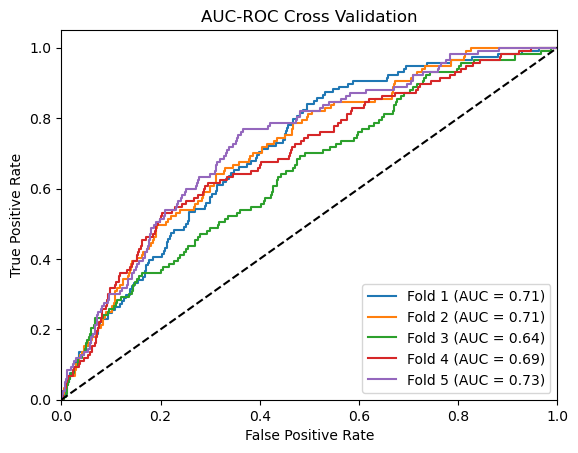

In [ ]:
#catboost
# kfold plotting chatgpt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt

#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    model = cbc_ntc_v2
    model.fit(X_train_fold, y_train_fold)
    y_proba = model.predict_proba(X_test_fold)[:,1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f'Fold {fold_num+1} (AUC = {roc_auc:.2f})')
    
    #RocCurveDisplay.from_predictions(y_test_fold, y_proba, label=f"Fold = {fold_num}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Cross Validation')
plt.legend(loc='lower right')
plt.show()

{'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x20d4f6d3b30>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x20d6a3ca000>,
 'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x20d6a3ca2a0>,
 'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x20d6a3ca570>,
 'border_count': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x20d6a3cb2f0>,
 'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x20d6a3ca9c0>,
 'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x20d6a3c8ad0>,
 'od_wait': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x20d6a3c8f80>,
 'auto_class_weights': ['Balanced'],
 'random_state': [42],
 'objective': ['Logloss']}

In [6]:
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [7]:
X.columns

Index(['down_payment_amount', 'disbursal_amount', 'requested_loan_amount',
       'loan_asset_cost', 'final_sanctioned_amount', 'original_emi_amount',
       'age', 'number_of_installments', 'total_income', 'product_description',
       'marital_status', 'occupation_type', 'loan_account_no',
       'monthly_income', 'dp_ratio', 'D3_within12months', 'industry_grp',
       'res_city_grp', 'res_state_grp', 'res_resident_status_grp',
       'branch_grp', 'manufacturer_grp'],
      dtype='object')